In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

import os
import ipywidgets

%matplotlib inline

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:13: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


In [2]:
simDir = "TDEM_fields_response_1km"

In [3]:
sigma_air = 1e-5
sigma_back = 1e-2
sigma_casing = 1e6

casing_diameter = 10e-2  
casing_t = 10e-3

mur_casing = 1.
casing_l = 1000
csz = 2.5 

In [4]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [5]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

In [6]:
timeSteps = [(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)]

model.timeSteps = timeSteps
print(model.timeSteps.sum())
print(len(model.timeSteps))

0.20422
187


In [7]:
model.diffusion_distance(2e-1)

5641.8958354775632

In [8]:
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [9]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8,
    npadz = 17,
    csz = csz,
#     pfz = 1.5,
)

509712


/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


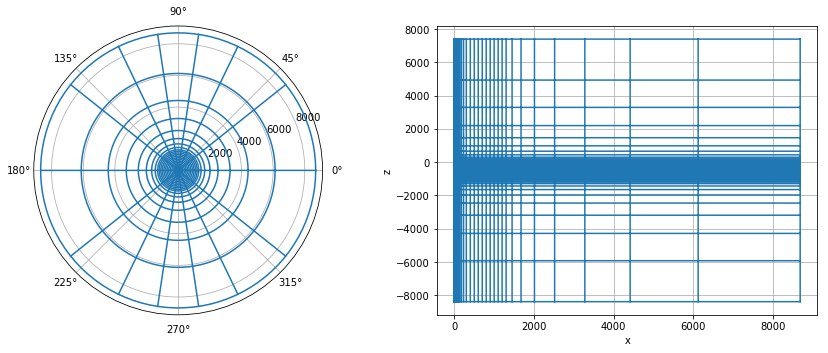

In [10]:
print(meshGen.mesh.nC)
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

In [11]:
physprops = casingSim.model.PhysicalProperties(
    modelParameters=model,
    meshGenerator=meshGen
)

In [12]:
from matplotlib.colors import LogNorm

[(-1250.0, 10.0), (-1250.0, 10.0)]

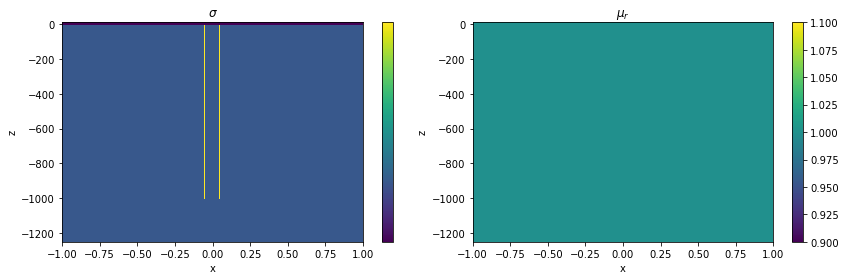

In [13]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

ax = physprops.plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

In [14]:
src = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

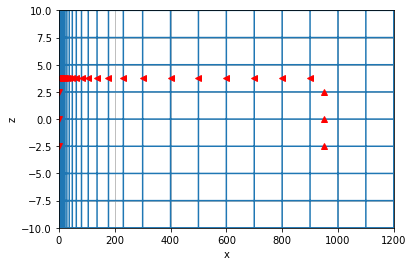

In [15]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 1200.])
ax.set_ylim([-10., 10.])

In [16]:
src.src_a_closest

array([ 0.04625   ,  1.57079633,  0.        ])

In [17]:
meshGen.mesh.gridFz[src.positive_electrode]

array([[ 0.04625   ,  1.57079633, -2.5       ],
       [ 0.04625   ,  1.57079633,  0.        ],
       [ 0.04625   ,  1.57079633,  2.5       ]])

(0.0, 60.0)

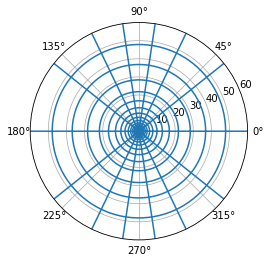

In [18]:
ax = meshGen.mesh.plotGrid(slice="z")
ax.set_rlim([0., 60.])

In [19]:
meshGen.mesh.vectorCCy[[3, 3+7]]*180/np.pi

array([  90.,  270.])

In [20]:
sim3D = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    src=src, 
)

In [21]:
sim3D.write_py(include2D=True, includeDC=False)

Saved TDEM_fields_response_1km/ModelParameters.json
Saved TDEM_fields_response_1km/MeshParameters.json
Saved TDEM_fields_response_1km/Source.json
wrote TDEM_fields_response_1km/simulation.py


# Load the results

In [22]:
import os

In [23]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir,
    modelParameters=simDir + os.path.sep + 'ModelParameters.json',
    meshGenerator=simDir + os.path.sep + 'MeshParameters.json',
    src=simDir + os.path.sep + 'Source.json',
    fields_filename=simDir + os.path.sep + 'fields.npy'
)

In [24]:
jSolution = np.load(simDir + os.path.sep + 'fields.npy')
jSolution2D = np.load(simDir + os.path.sep + 'fields2D.npy')

In [25]:
sim.prob.model = sim.physprops.model

In [26]:
%%time
# recreate the fields object
fields = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)

CPU times: user 1min 12s, sys: 2.31 s, total: 1min 15s
Wall time: 1min 24s


In [27]:
fields[:,'jSolution',:] = jSolution

In [28]:
sim2D = casingSim.run.SimulationTDEM(
    directory=simDir,
    modelParameters=simDir + os.path.sep + 'ModelParameters.json',
    meshGenerator=sim.meshGenerator.create_2D_mesh(),
    src=simDir + os.path.sep + 'Source.json',
    fields_filename=simDir + os.path.sep + 'fields2D.npy'
)
sim2D.prob.model = sim2D.physprops.model
fields2D = sim2D.prob.fieldsPair(sim2D.meshGenerator.mesh, sim2D.survey)
fields2D[:,'jSolution',:] = jSolution2D

# Plot Comparison

In [29]:
# Plot the charges
src_ind=0

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='j',  
    casing_outline=True, 
    theta_ind=0, 
    time_ind=0, 
    mod='3D'
):
    if mod == '3D':
        csim = sim
        mesh2D = sim.meshGenerator.create_2D_mesh().mesh
        f = fields
    elif mod == '2D':
        csim = sim2D
        mesh2D = sim2D.meshGenerator.mesh
        f = fields2D
        theta_ind=0
        
    pp = csim.physprops
    src = csim.survey.srcList[src_ind]
    meshGen = csim.meshGenerator
    plotme = f[src, view, time_ind]
        
    if ax is None: 
        plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['j', 'e']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
    
    if view in ['j', 'e']:
        jplt = casingSim.face3DthetaSlice(
            meshGen.mesh, plotme, theta_ind=theta_ind
        )
        if mod == '3D':
            mirror_data = casingSim.face3DthetaSlice(
                meshGen.mesh, plotme, theta_ind=theta_ind + 7
            )
        else:
            mirror_data = jplt

        _, cb = casingSim.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True, mirror_data=mirror_data
        )
    ax.set_title(
        '{} {} \n theta = {:1.2f} \n time = {:1.2e}'.format(
            view, mod, meshGen.mesh.vectorCCy[theta_ind]*180/np.pi, csim.prob.times[time_ind]
            
        ), 
        fontsize=13
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
        
    # plot outline of casing
    if casing_outline is True: 
        m = model
        factor = [1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return ax 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='j',  
    theta_ind=0, time_ind=0, mod='3D', 
    figwidth = 5
):
    
    if mod == "both":
        mod = ['2D', '3D']
    else:
        mod = [mod]
        
    fig, ax = plt.subplots(1, len(mod), figsize=(figwidth*len(mod), 6))
    
    if len(mod) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, mod): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view,
            casing_outline=True, 
            theta_ind=theta_ind,
            time_ind=time_ind,
            mod=mod
        )
    
    plt.tight_layout()
    plt.show()

In [30]:
ipywidgets.interact(plotCasingResultsWidget,
    clim_max=ipywidgets.FloatText(value=1e2), 
    clim_min=ipywidgets.FloatText(value=1e-10), 
    max_depth=ipywidgets.FloatText(value=1.5*model.casing_l), 
    max_r=ipywidgets.FloatText(value=0.15), 
    top=ipywidgets.FloatText(value=10.), 
    view=ipywidgets.ToggleButtons(options=['j', 'e'], value='j'),  
    theta_ind=ipywidgets.IntSlider(min=0, max=len(sim.meshGenerator.hy), value=3),
    time_ind=ipywidgets.IntSlider(min=0, max=len(sim.modelParameters.timeSteps), value=0), 
    mod=ipywidgets.ToggleButtons(options=['2D', '3D', 'both'], value='both'),
    figwidth=ipywidgets.fixed(5)
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plotCasingResultsWidget>

In [31]:
ipywidgets.interact(plotCasingResultsWidget,
    clim_max=ipywidgets.FloatText(value=1e-1), 
    clim_min=ipywidgets.FloatText(value=1e-11), 
    max_depth=ipywidgets.FloatText(value=1.5*model.casing_l), 
    max_r=ipywidgets.FloatText(value=1.5*model.casing_l), 
    top=ipywidgets.FloatText(value=10.), 
    view=ipywidgets.ToggleButtons(options=['j', 'e'], value='j'),  
    theta_ind=ipywidgets.IntSlider(min=0, max=len(sim.meshGenerator.hy), value=3),
    time_ind=ipywidgets.IntSlider(min=0, max=len(sim.modelParameters.timeSteps), value=0), 
    mod=ipywidgets.ToggleButtons(options=['2D', '3D', 'both'], value='3D'),
    figwidth=ipywidgets.fixed(12)
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plotCasingResultsWidget>

In [32]:
nC = 200
hx = 3000.*np.ones(nC)/nC
plan_mesh = discretize.TensorMesh([hx, hx], x0='CC')

In [33]:
cylmesh = meshGen.mesh

In [34]:
CCcart = meshGen.mesh.cartesianGrid('CC')

In [35]:
def rotate_cyl2cart(vec, grid):
    x = vec[:, 0] * np.cos(grid[:, 1]) - vec[:, 1] * np.sin(grid[:, 1])
    y = vec[:, 0] * np.sin(grid[:, 1]) + vec[:, 1] * np.cos(grid[:, 1])
    z = vec[:, 2]
    
    return np.vstack([x, y, z]).T
    

In [36]:
vec = np.r_[1, 0, 0].reshape(1, 3)
grid = np.r_[1, np.pi/4, 0].reshape(1, 3)

print(rotate_cyl2cart(vec, grid))


vec = np.r_[0, 1, 0].reshape(1, 3)
grid = np.r_[1, np.pi/4, 0].reshape(1, 3)

print(rotate_cyl2cart(vec, grid))

[[ 0.70710678  0.70710678  0.        ]]
[[-0.70710678  0.70710678  0.        ]]


In [37]:
tree = cKDTree(CCcart[:cylmesh.vnC[:2].prod(),:2])
d, ii = tree.query(plan_mesh.gridCC, k=10)
inds = np.vstack([ii, ii+cylmesh.vnC[:2].prod()])

In [38]:
ii.shape[0]

40000

In [39]:
weights = 1./d
weights = utils.sdiag(1./weights.sum(1))*weights
weights = np.vstack([weights, weights])

In [40]:
clim_max=1e-4
clim_min=1e-9

def plot_depth_slice(
    time_ind=0,
    z_ind=400,
    ax=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
    
    jCC = cylmesh.aveF2CCV * fields[:, 'j', time_ind]
    jCC_cart = rotate_cyl2cart(jCC.reshape((cylmesh.nC, 3), order='F'), cylmesh.gridCC)
    
    jCCx = (jCC_cart[:, 0]).reshape(cylmesh.vnC, order='F')
    jCCy = (jCC_cart[:, 1]).reshape(cylmesh.vnC, order='F')
    
    jCCx_plt = utils.mkvc(jCCx[:, :, z_ind])
    jCCy_plt = utils.mkvc(jCCy[:, :, z_ind])
    jCC_plt = np.hstack([jCCx_plt, jCCy_plt])
    
    plot_me = (jCC_plt[inds]*weights).sum(1)

    ax.set_title("z={:1.1f}m, \n t={:1.1e}".format(
        cylmesh.vectorCCz[z_ind], sim.prob.times[time_ind]
    ))

    cb = plt.colorbar(plan_mesh.plotImage(
        plot_me, view='vec', vType='CCv', ax=ax, pcolorOpts={'norm':LogNorm()},
        clim = [clim_min, clim_max]
    )[0], ax=ax)
    
    plt.show()

In [41]:
ipywidgets.interact(
    plot_depth_slice,
    z_ind = ipywidgets.IntSlider(min=0, max=cylmesh.vnC[2], value=400),
    time_ind = ipywidgets.IntSlider(min=0, max=len(sim.prob.timeSteps), value=0),
    ax = ipywidgets.fixed(None)
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plot_depth_slice>

# Print Figures

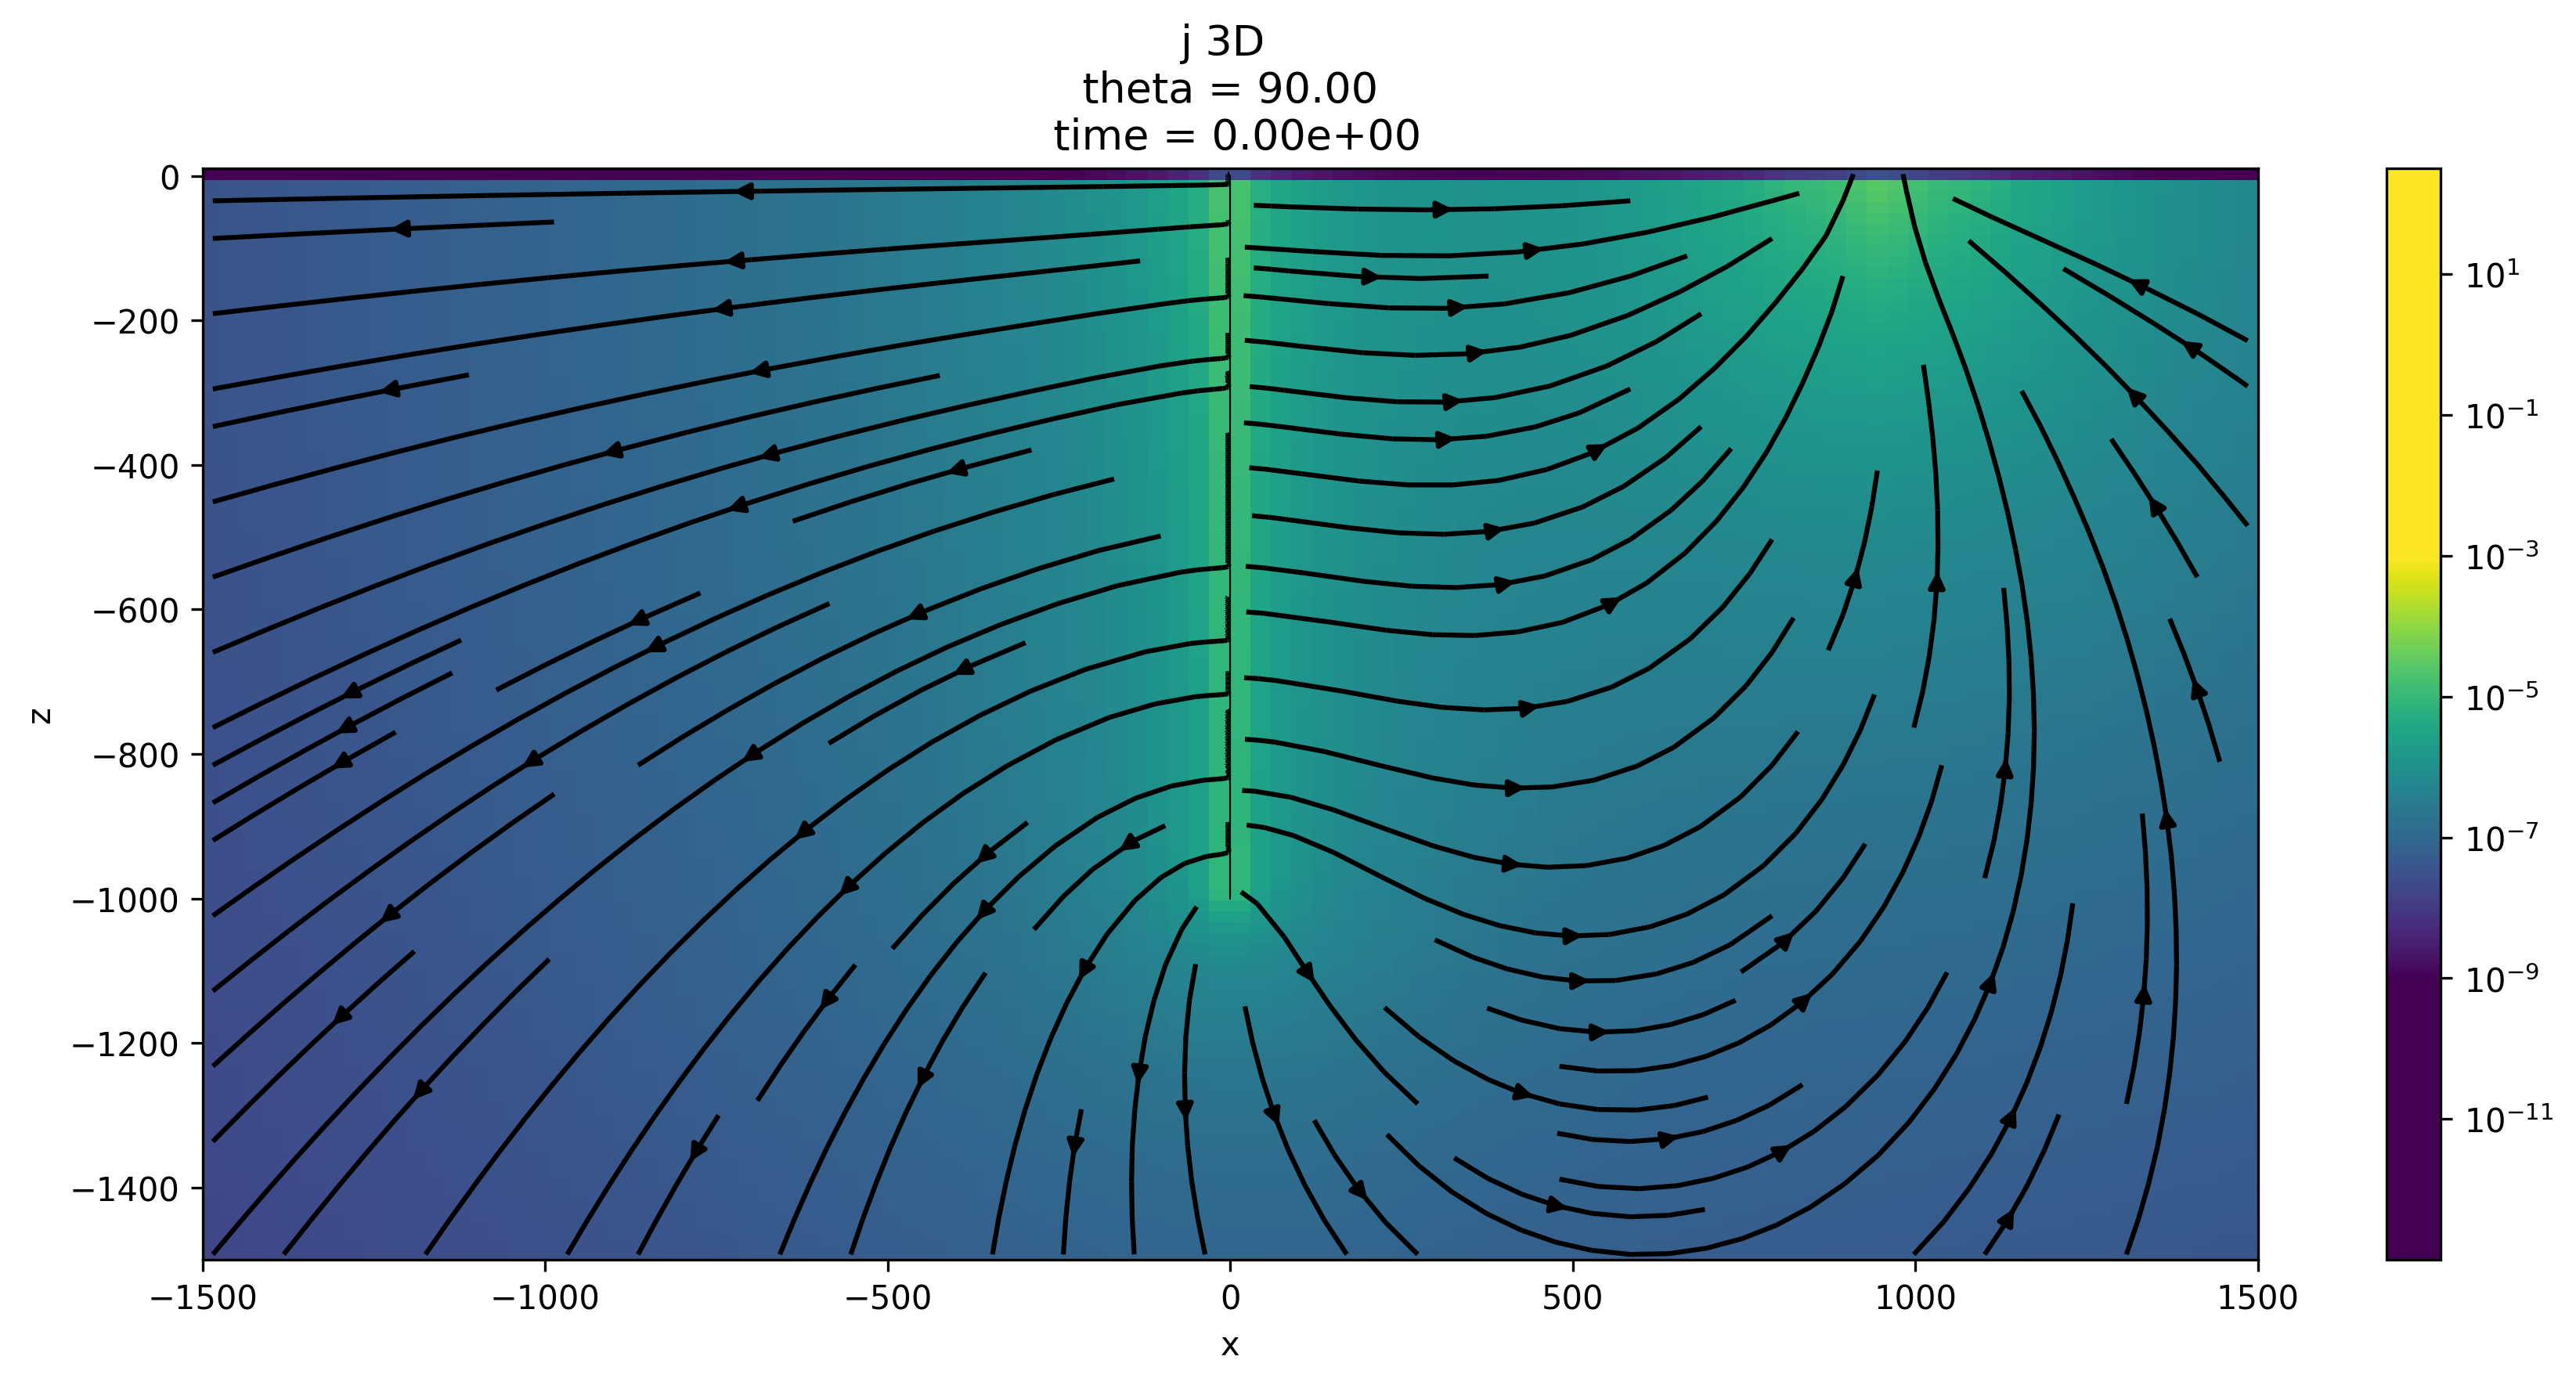

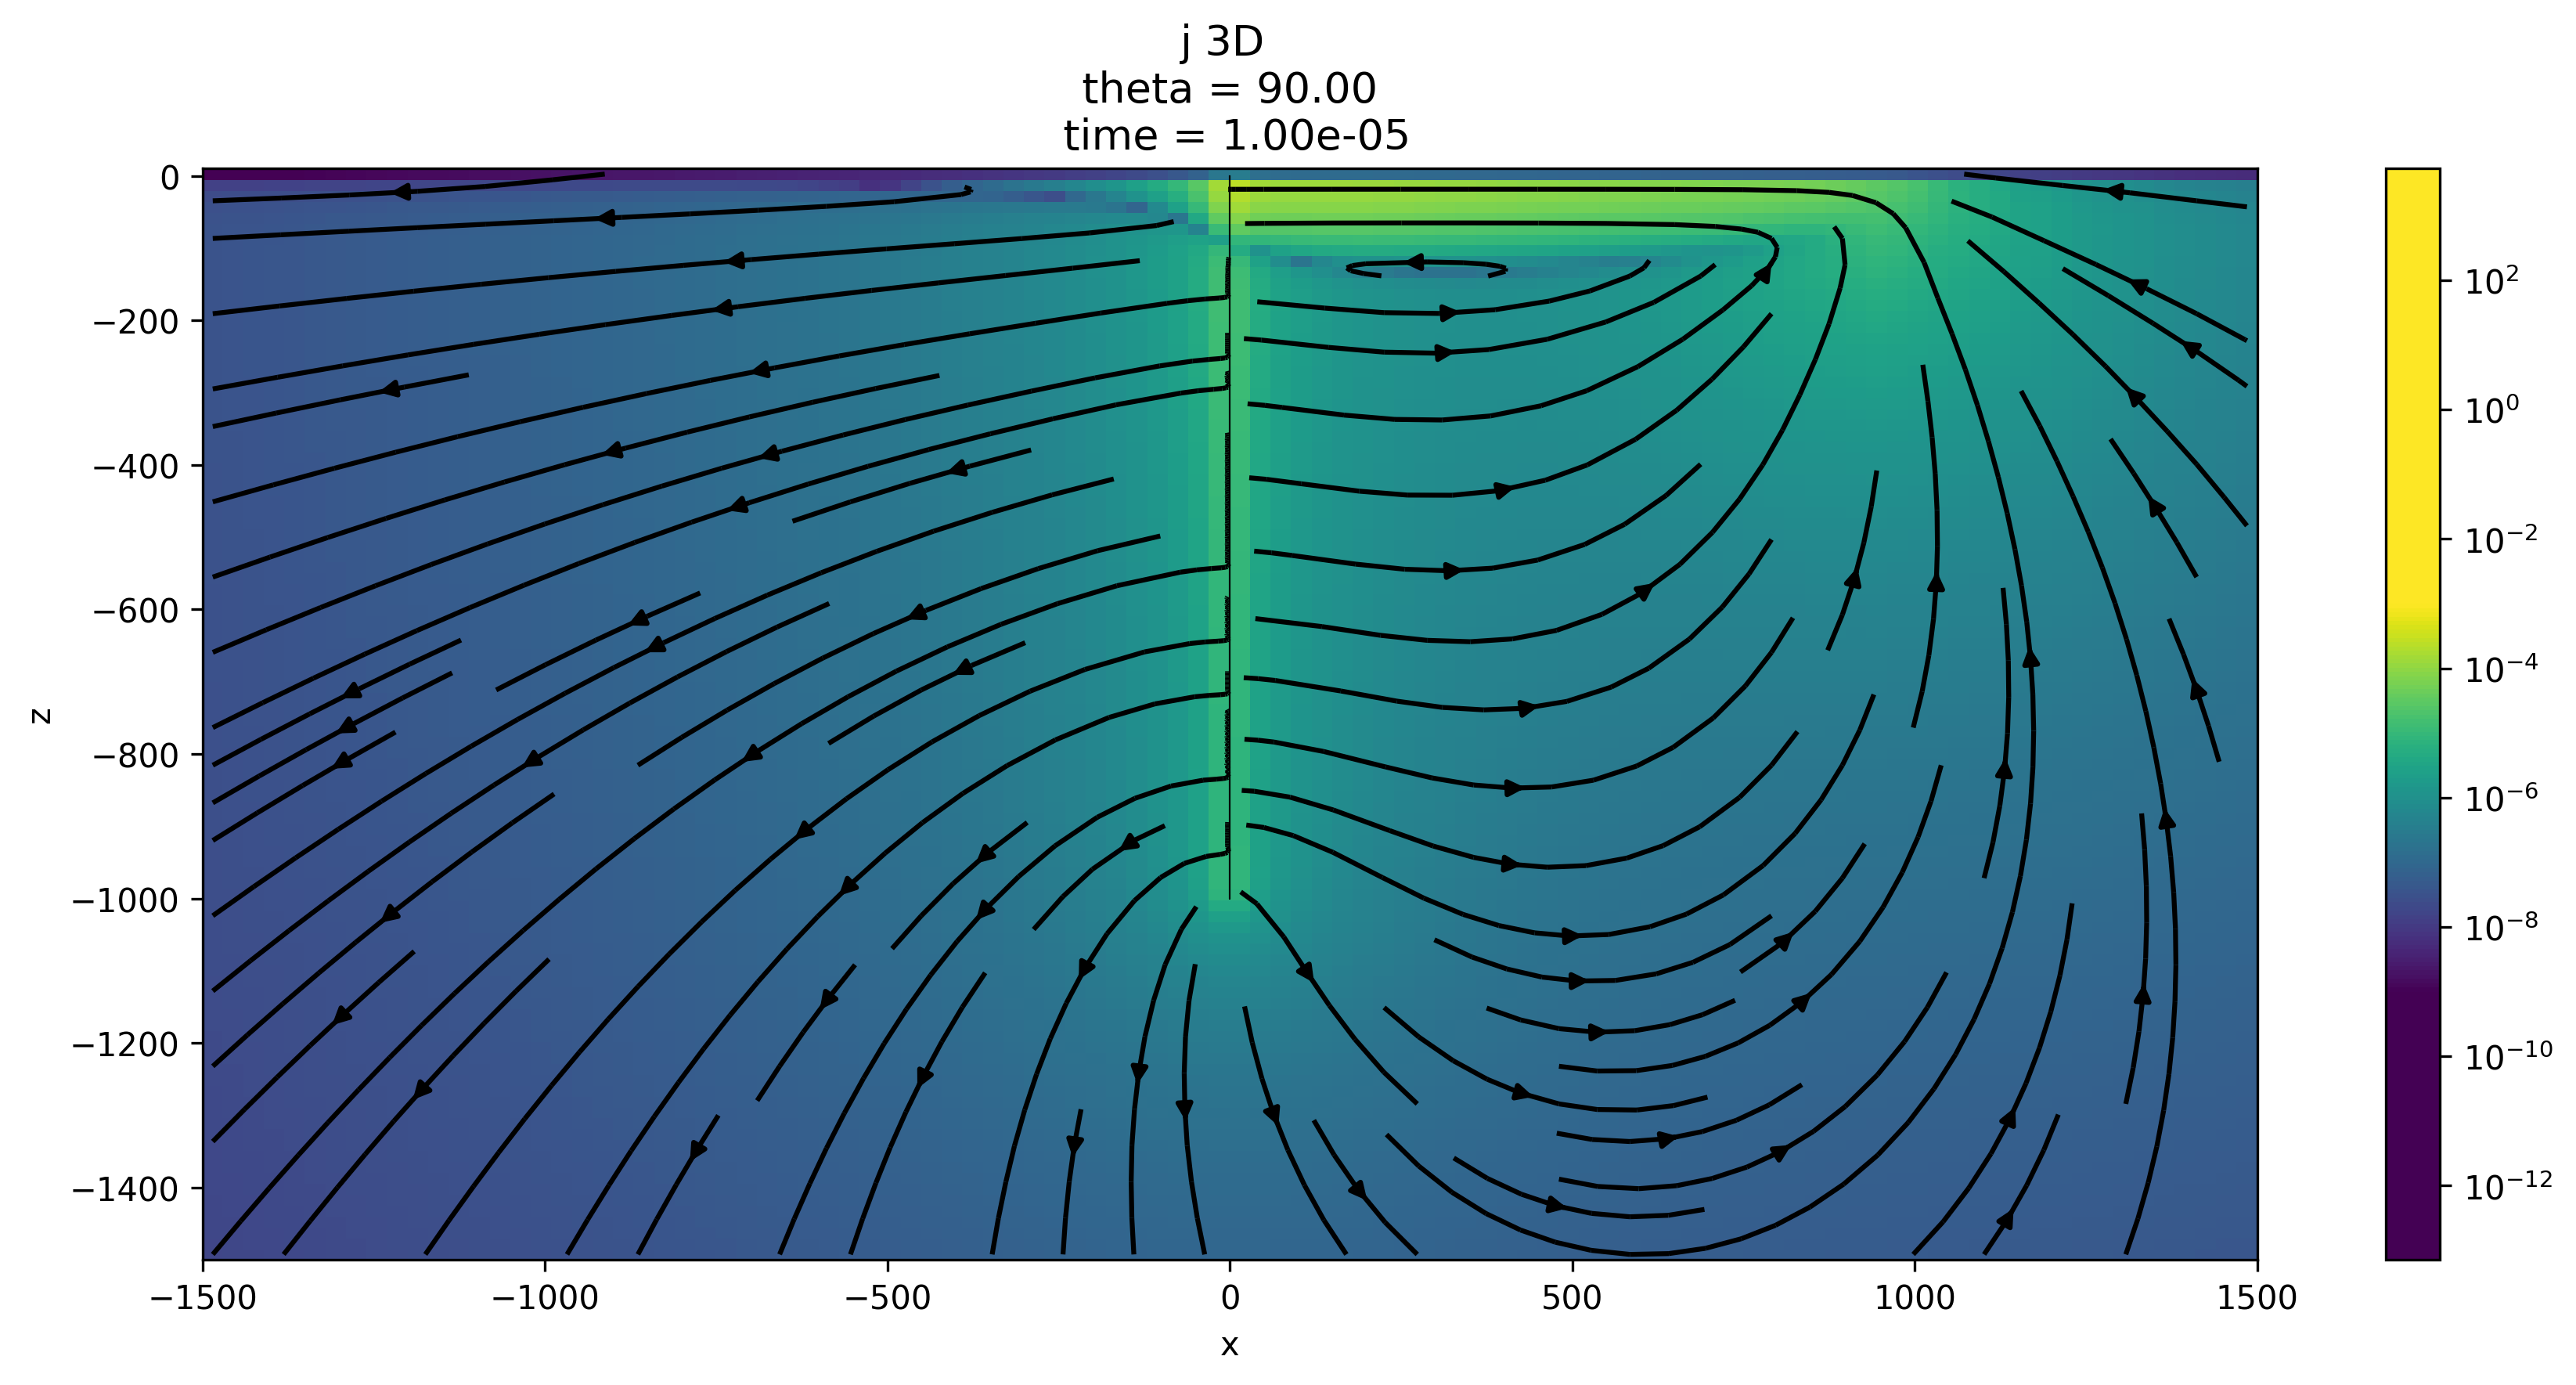

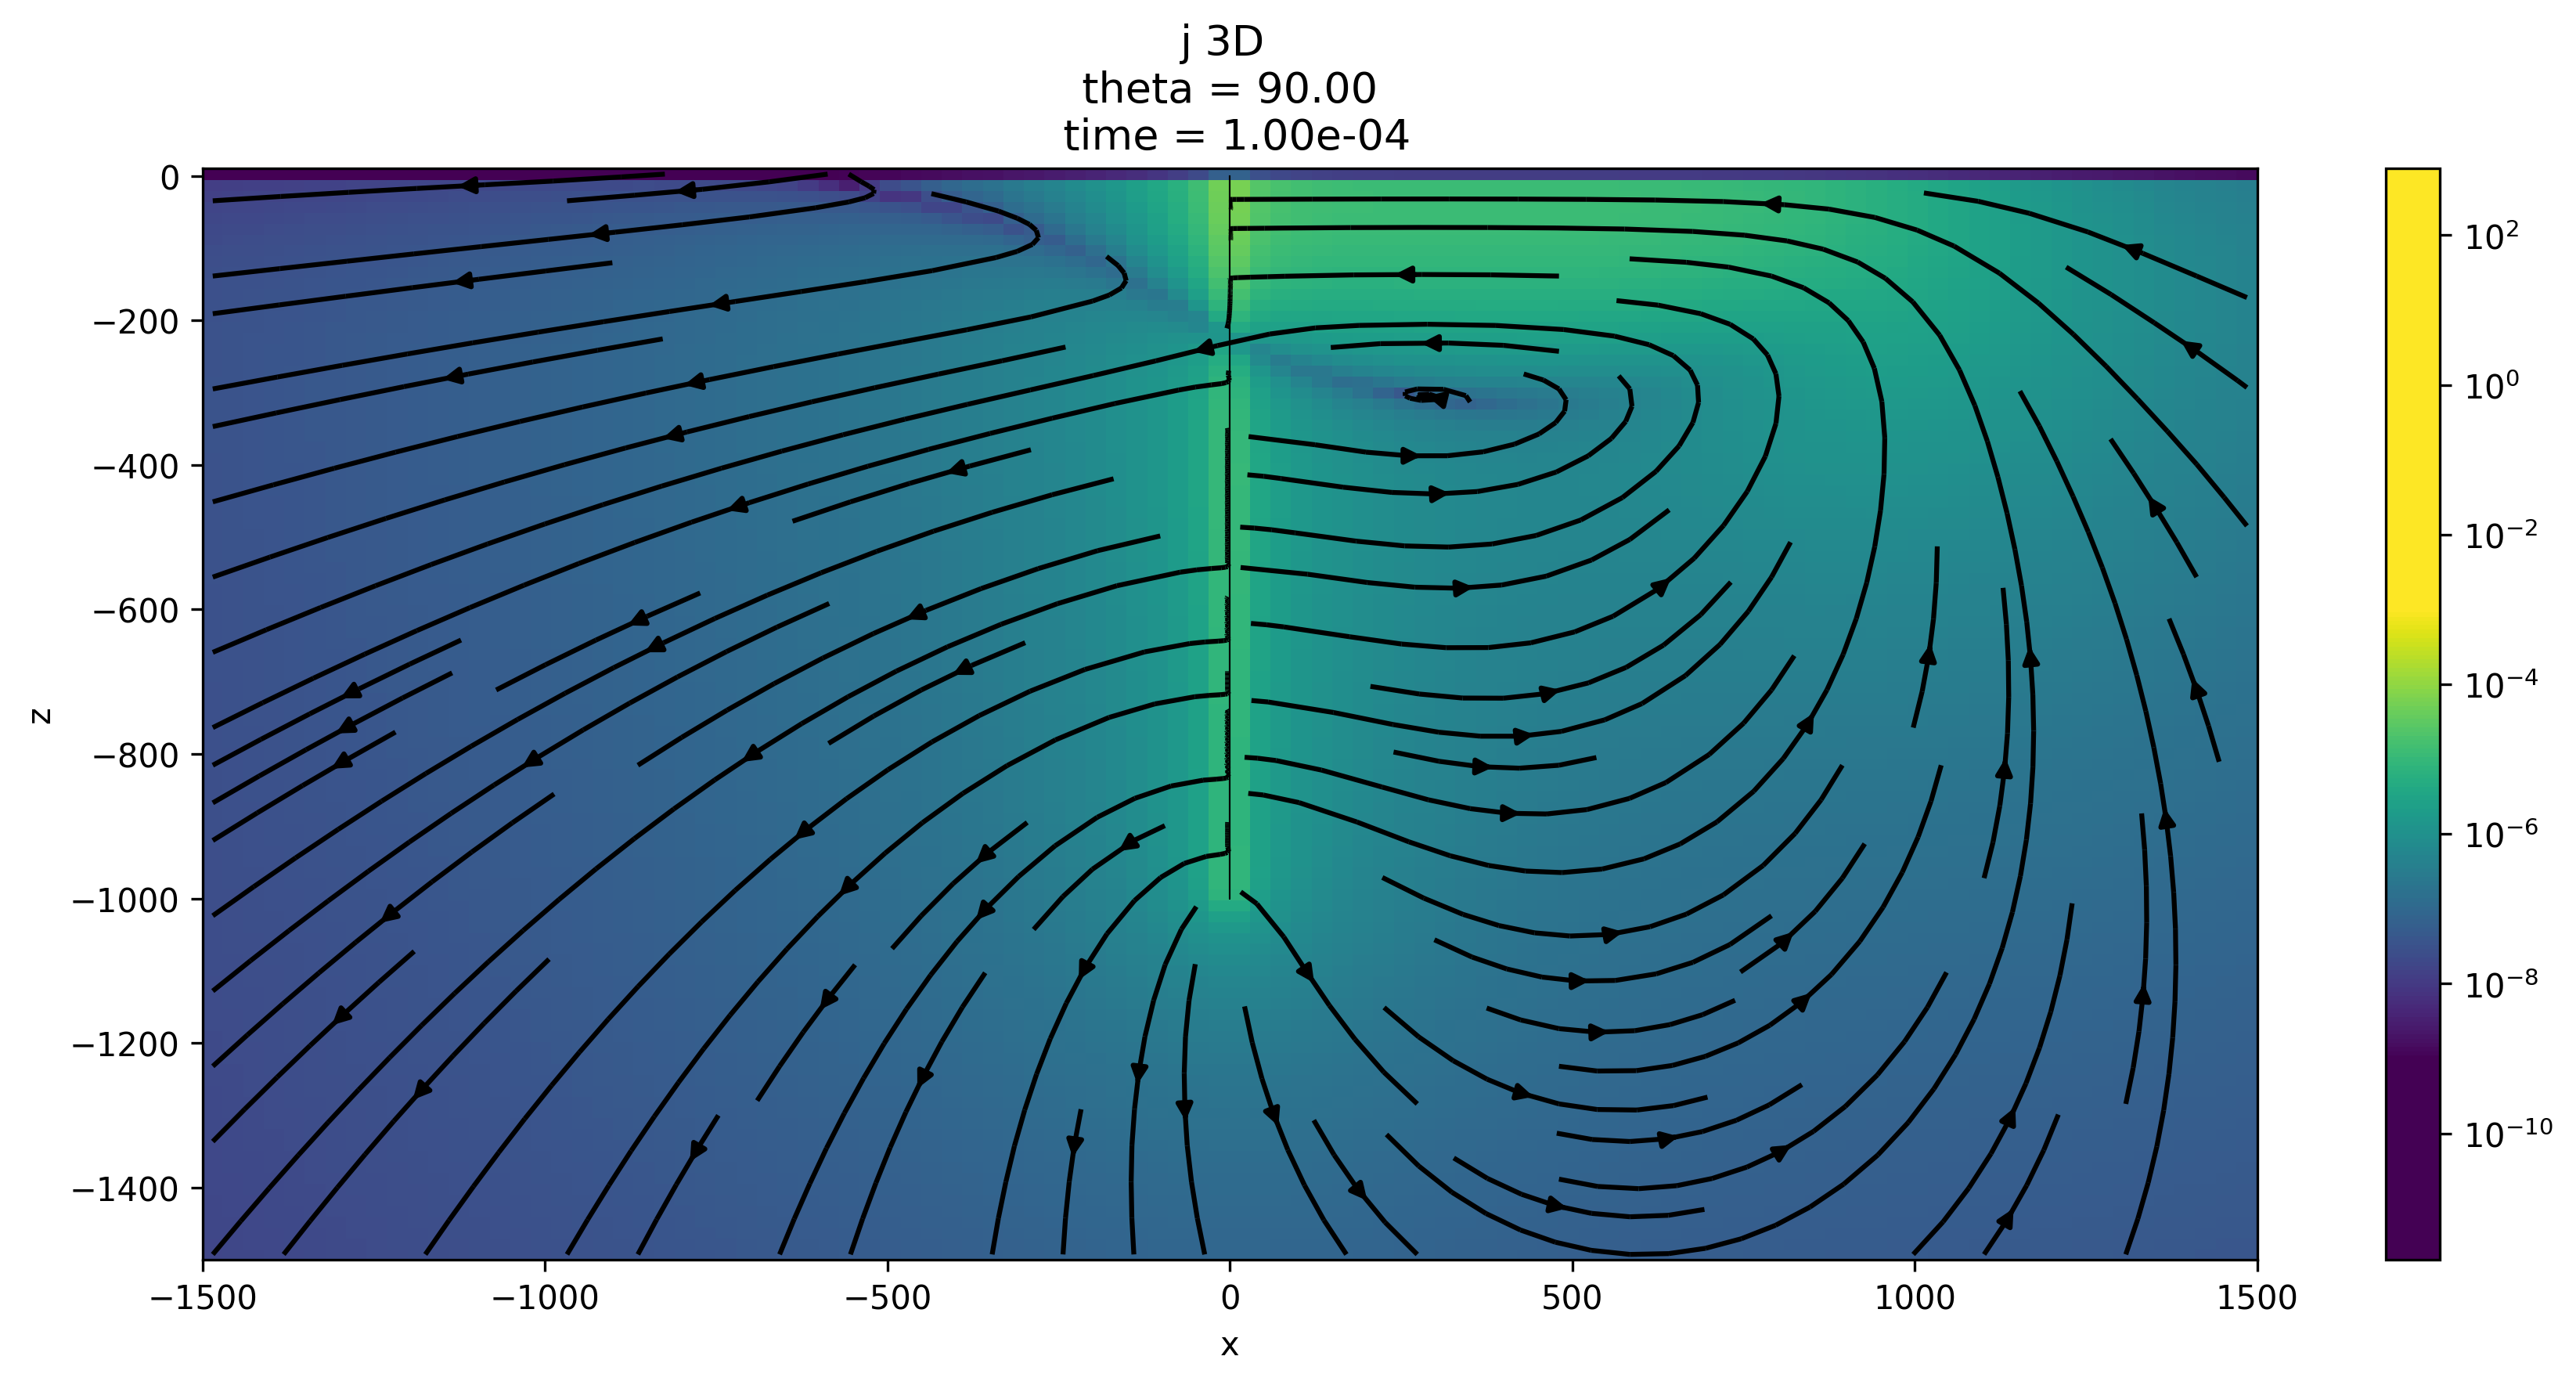

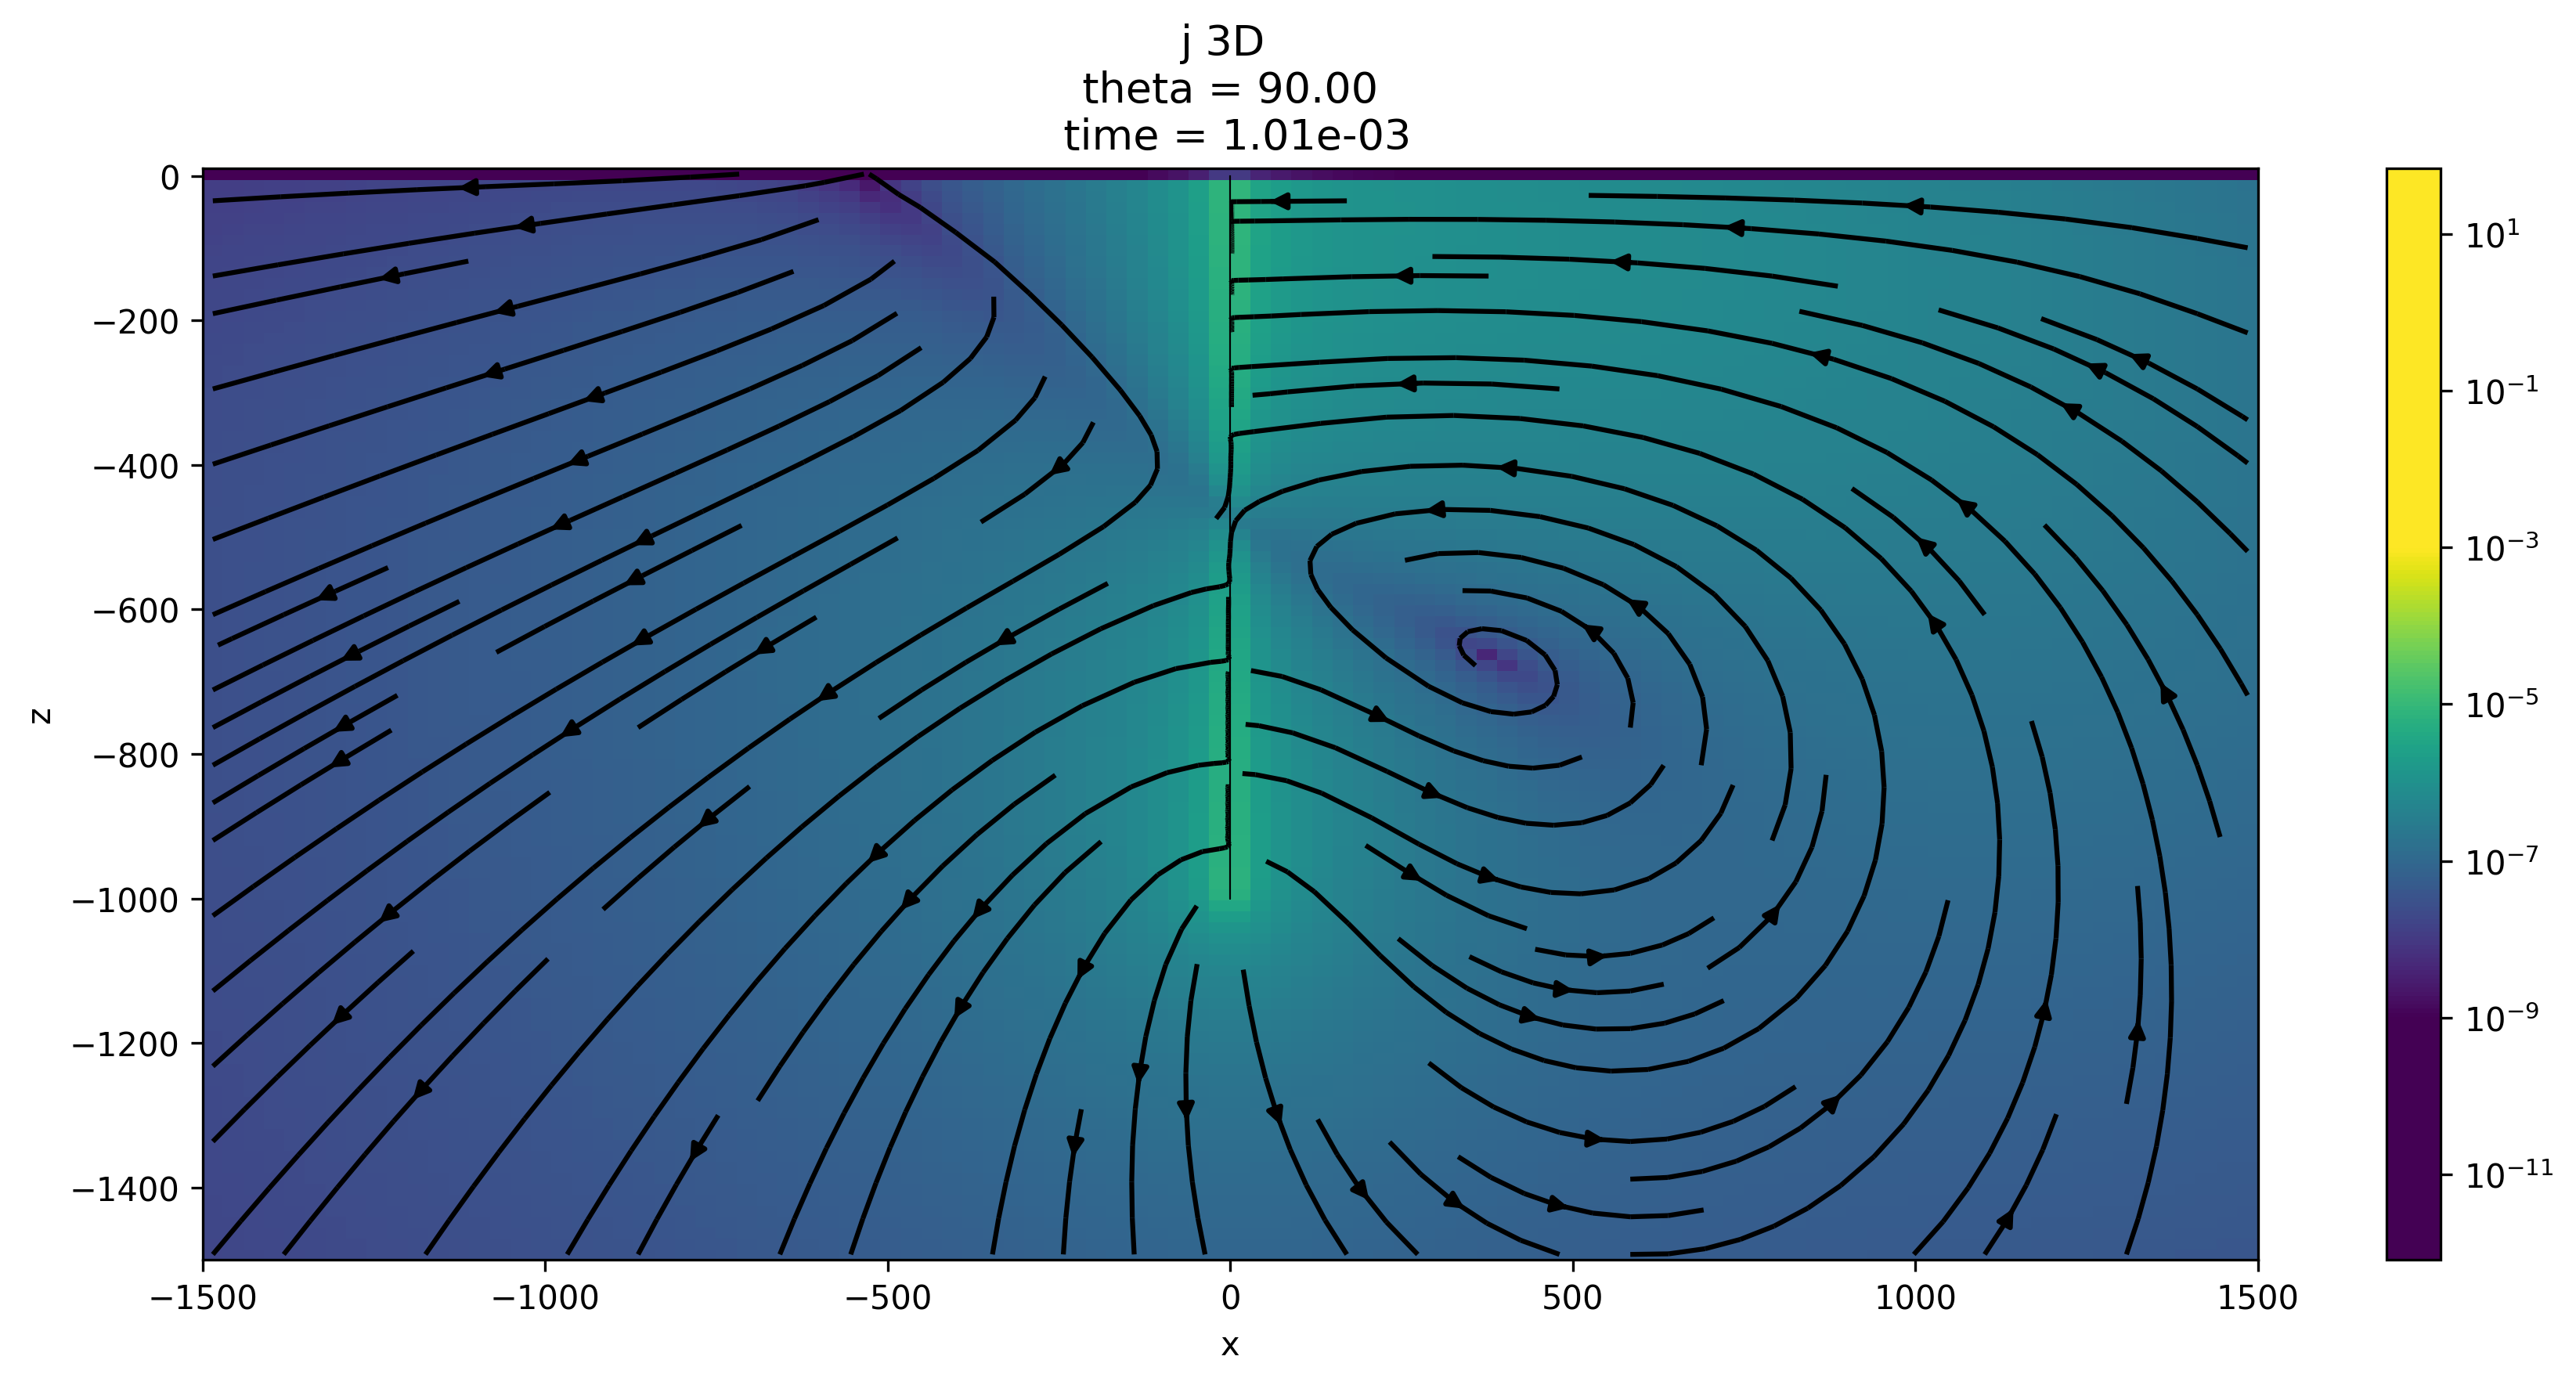

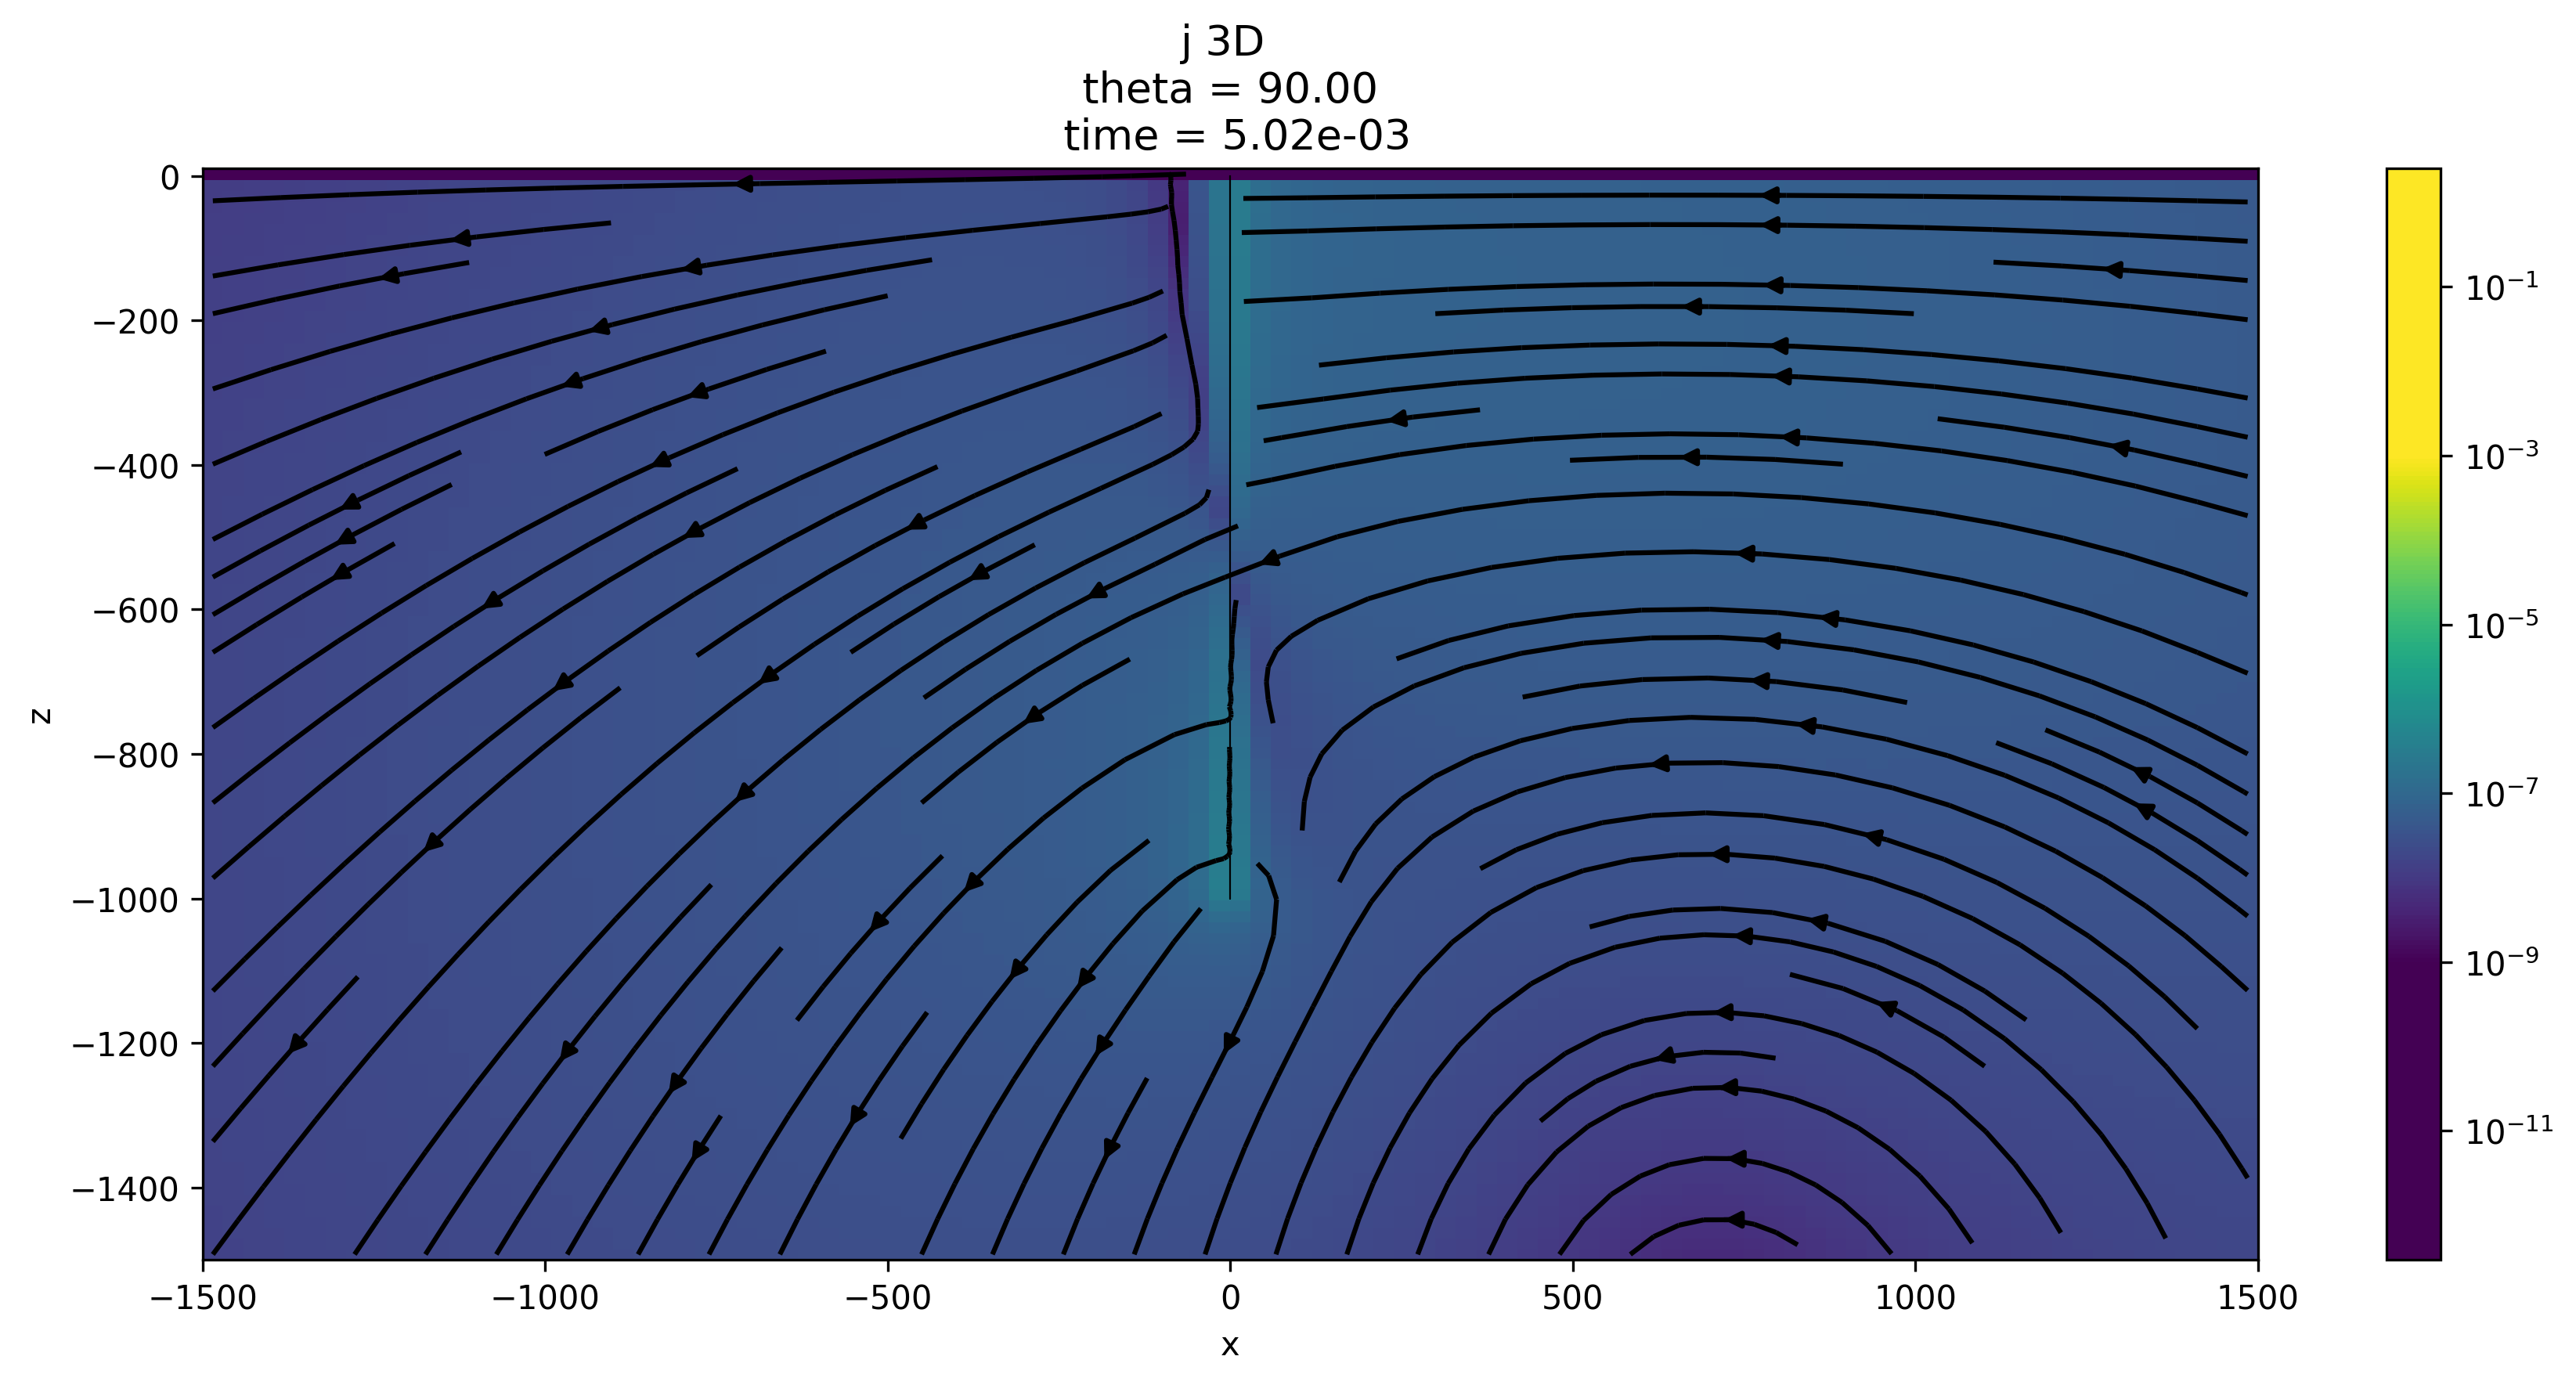

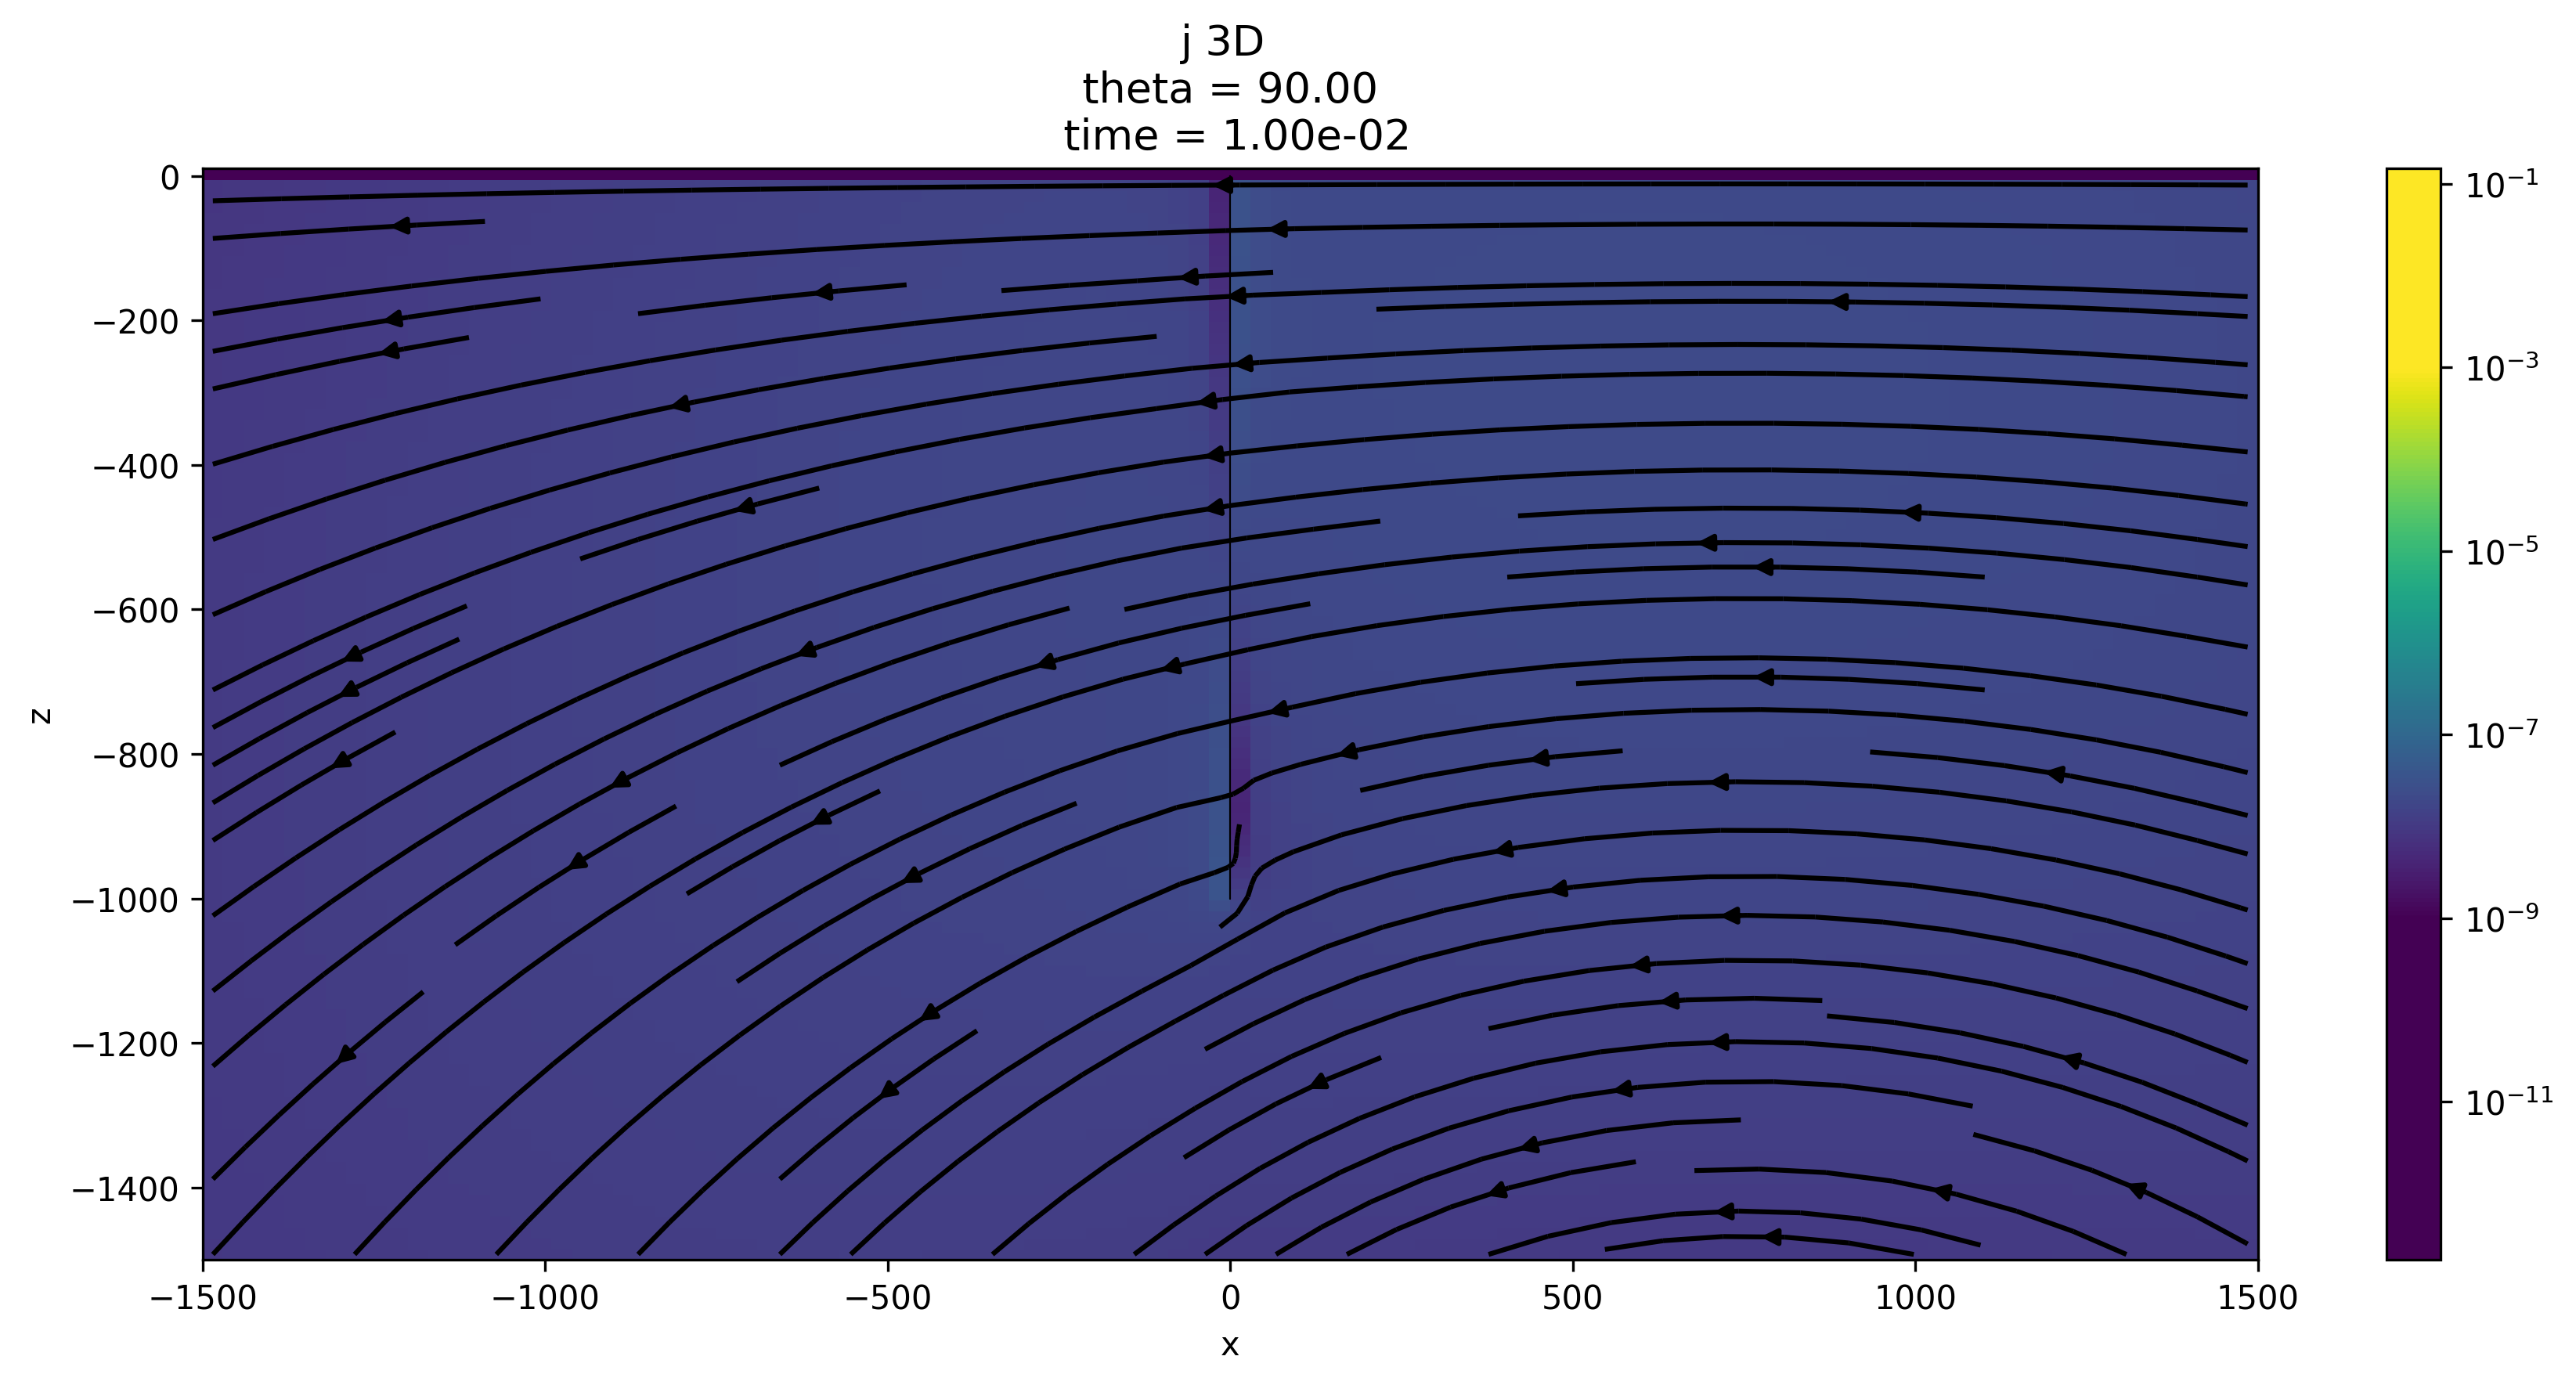

In [42]:
mod = ['3D']

for tind in [0, 10, 28, 73, 118, 136]:
# tind = 136
    fig, ax = plt.subplots(1, len(mod), figsize=(12*len(mod), 6), dpi=300)
    if len(mod) == 1:
        ax = [ax]

    for a, m in zip(ax, mod): 
        a = plotCasingResults(
            ax = a,
            clim_max=1e-3, clim_min=1e-9, 
            max_depth=1.5*model.casing_l, 
            max_r=1.5*casing_l, top=10, view='j',
            casing_outline=True, 
            theta_ind=3,
            time_ind=tind,
            mod=m
        )

    plt.tight_layout()
    plt.show()

In [43]:
sim.prob.times[[0, 10, 28, 73, 118, 136]]

array([  0.00000000e+00,   1.00000000e-05,   1.00000000e-04,
         1.01000000e-03,   5.02000000e-03,   1.00200000e-02])

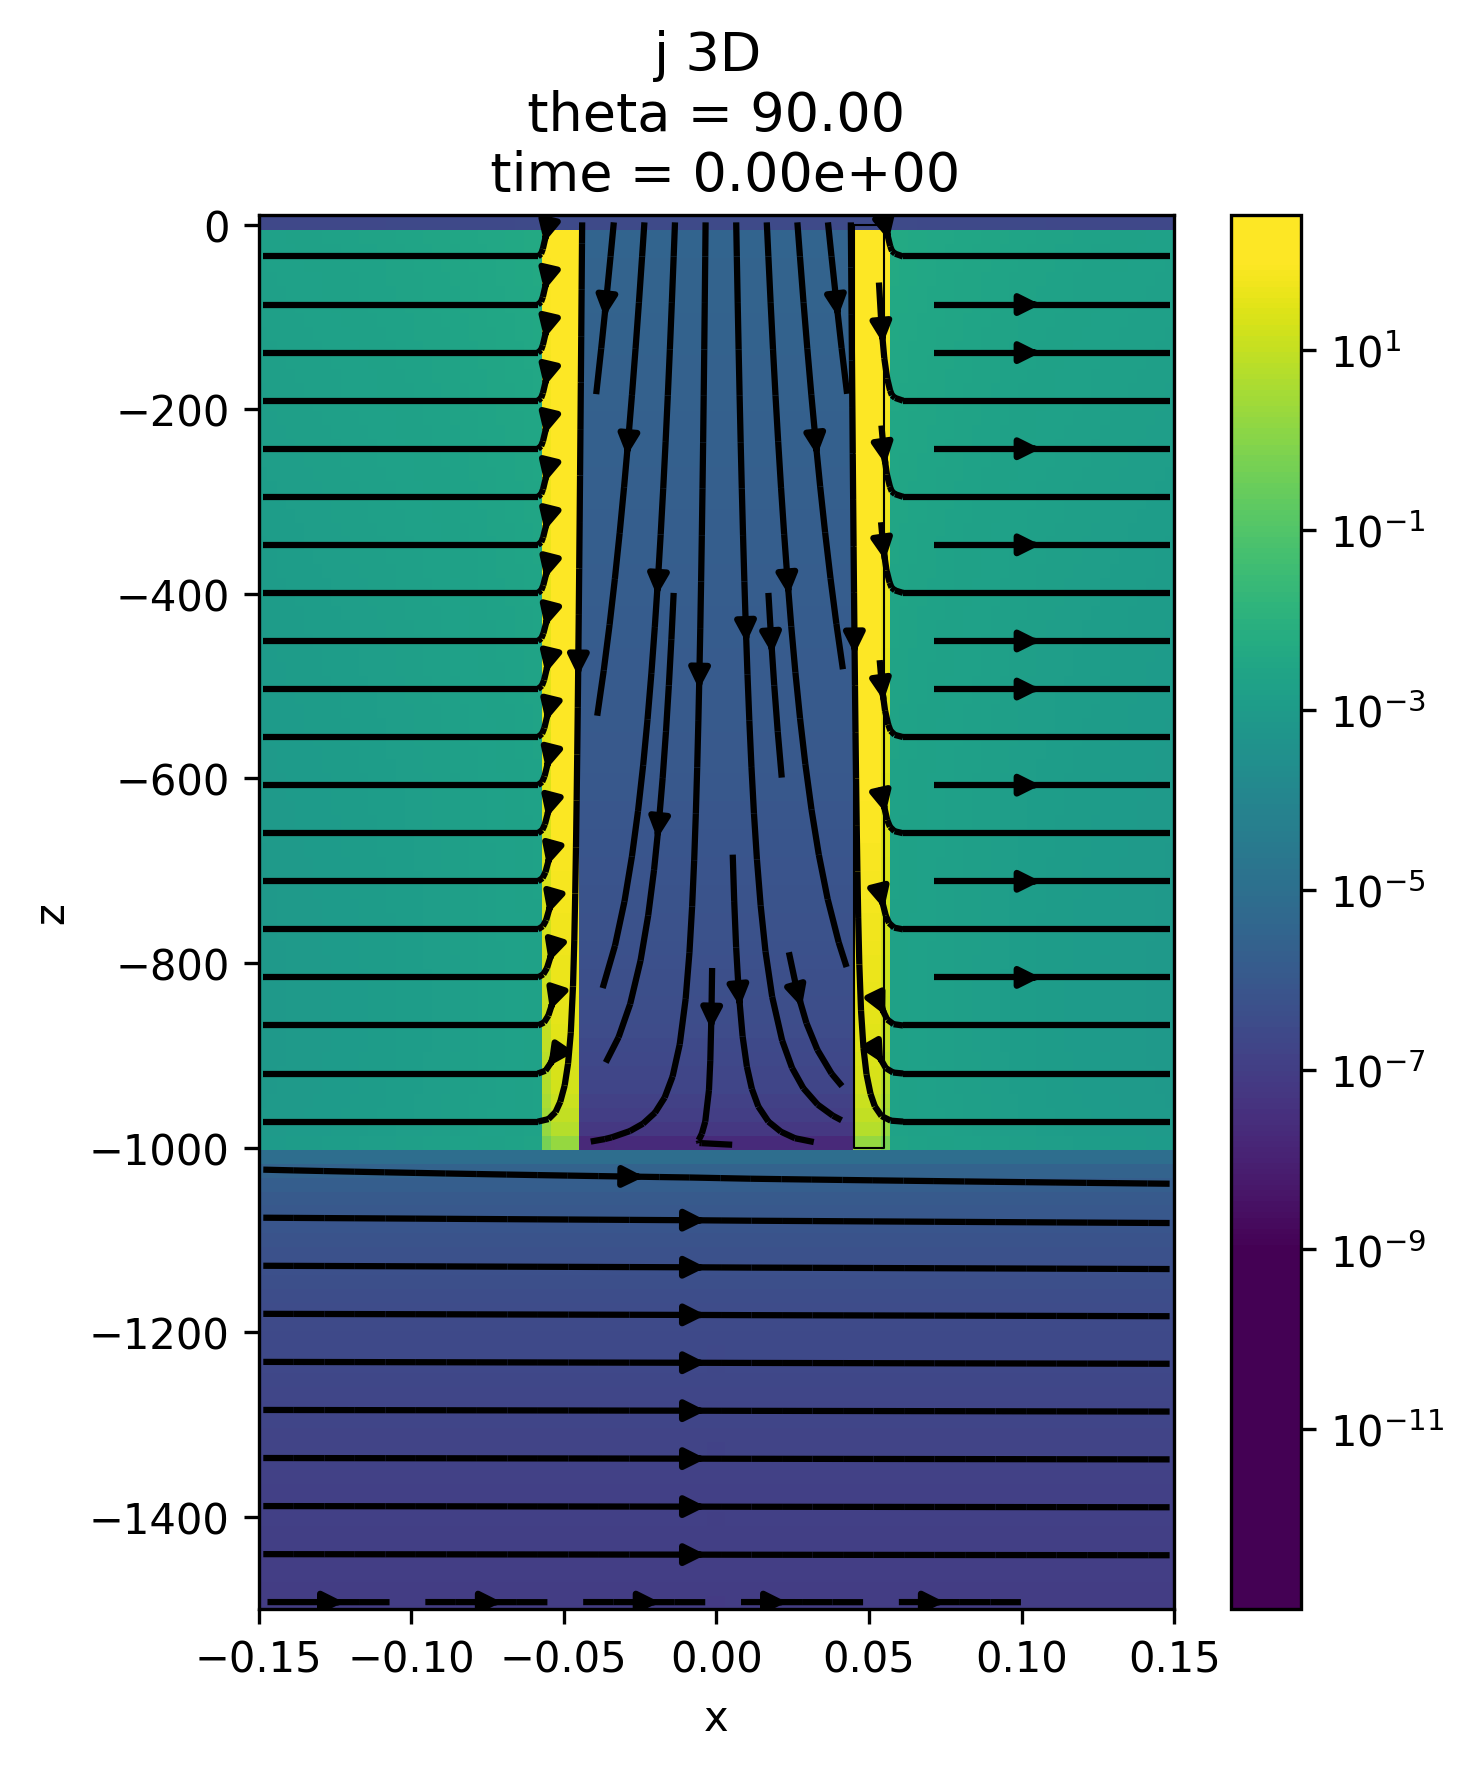

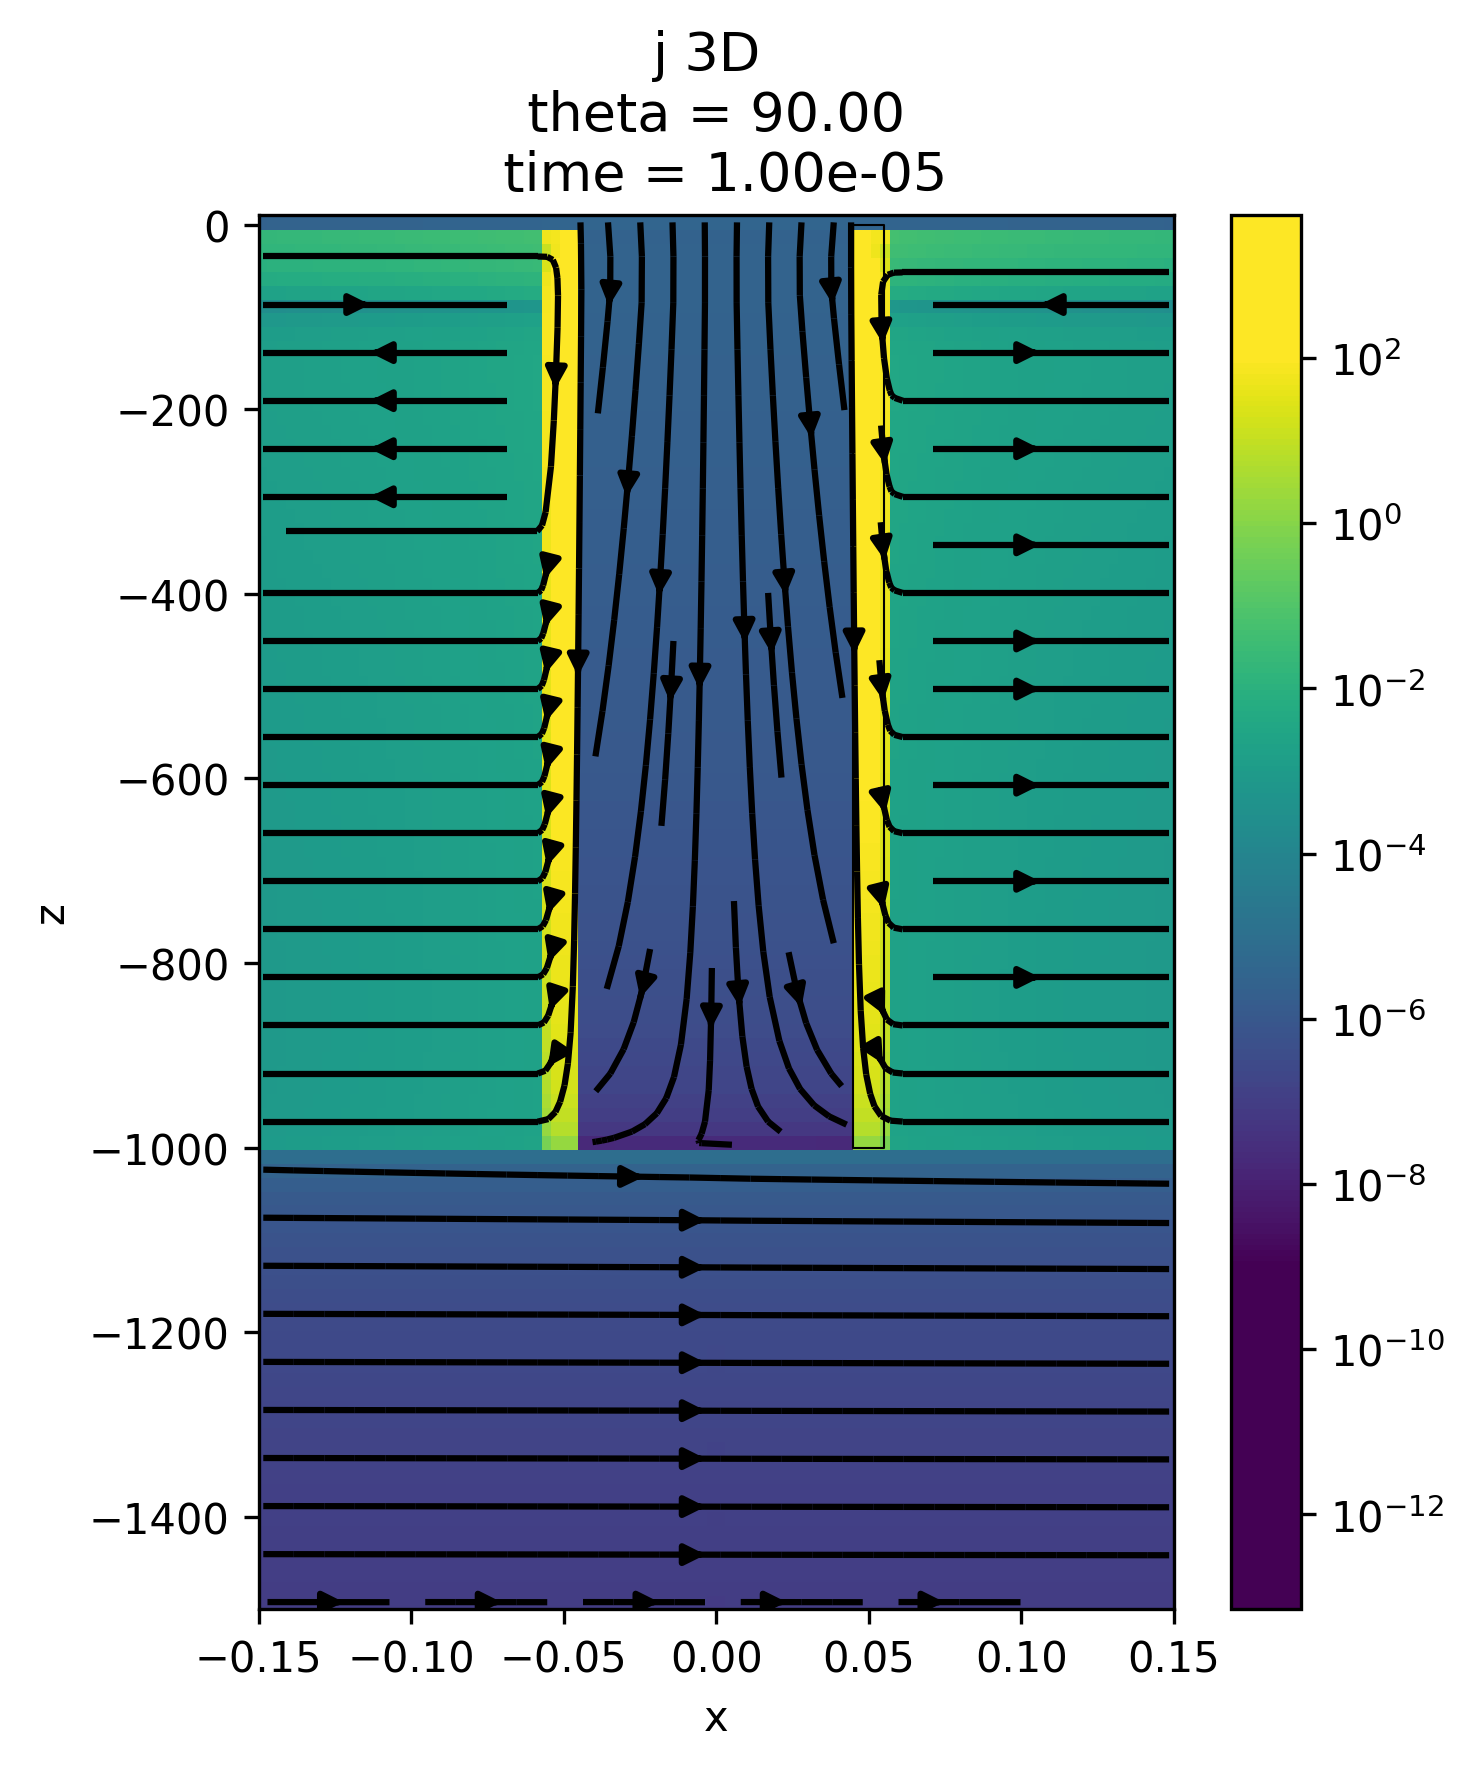

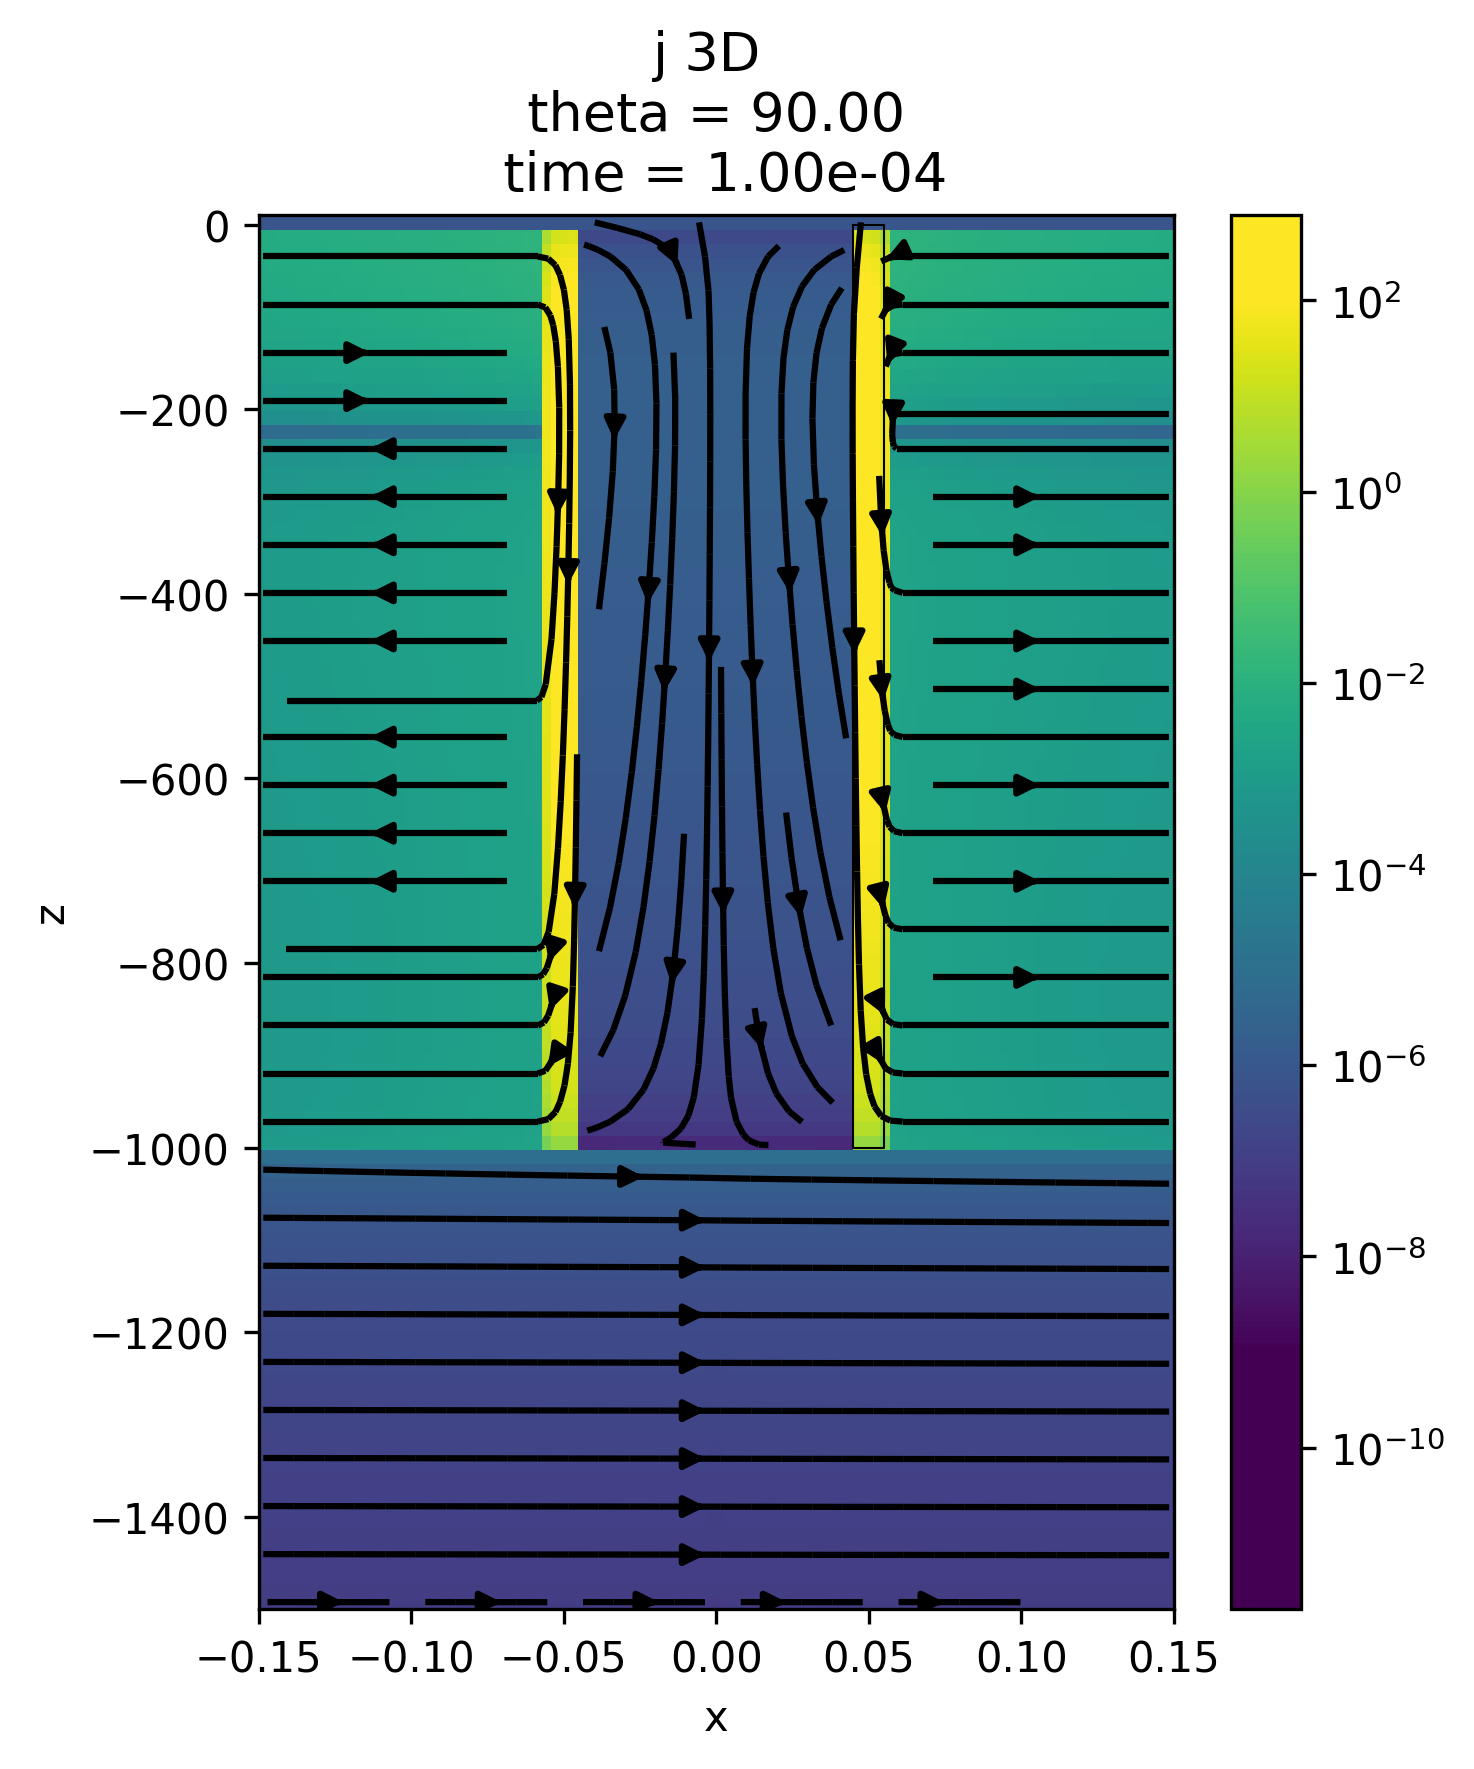

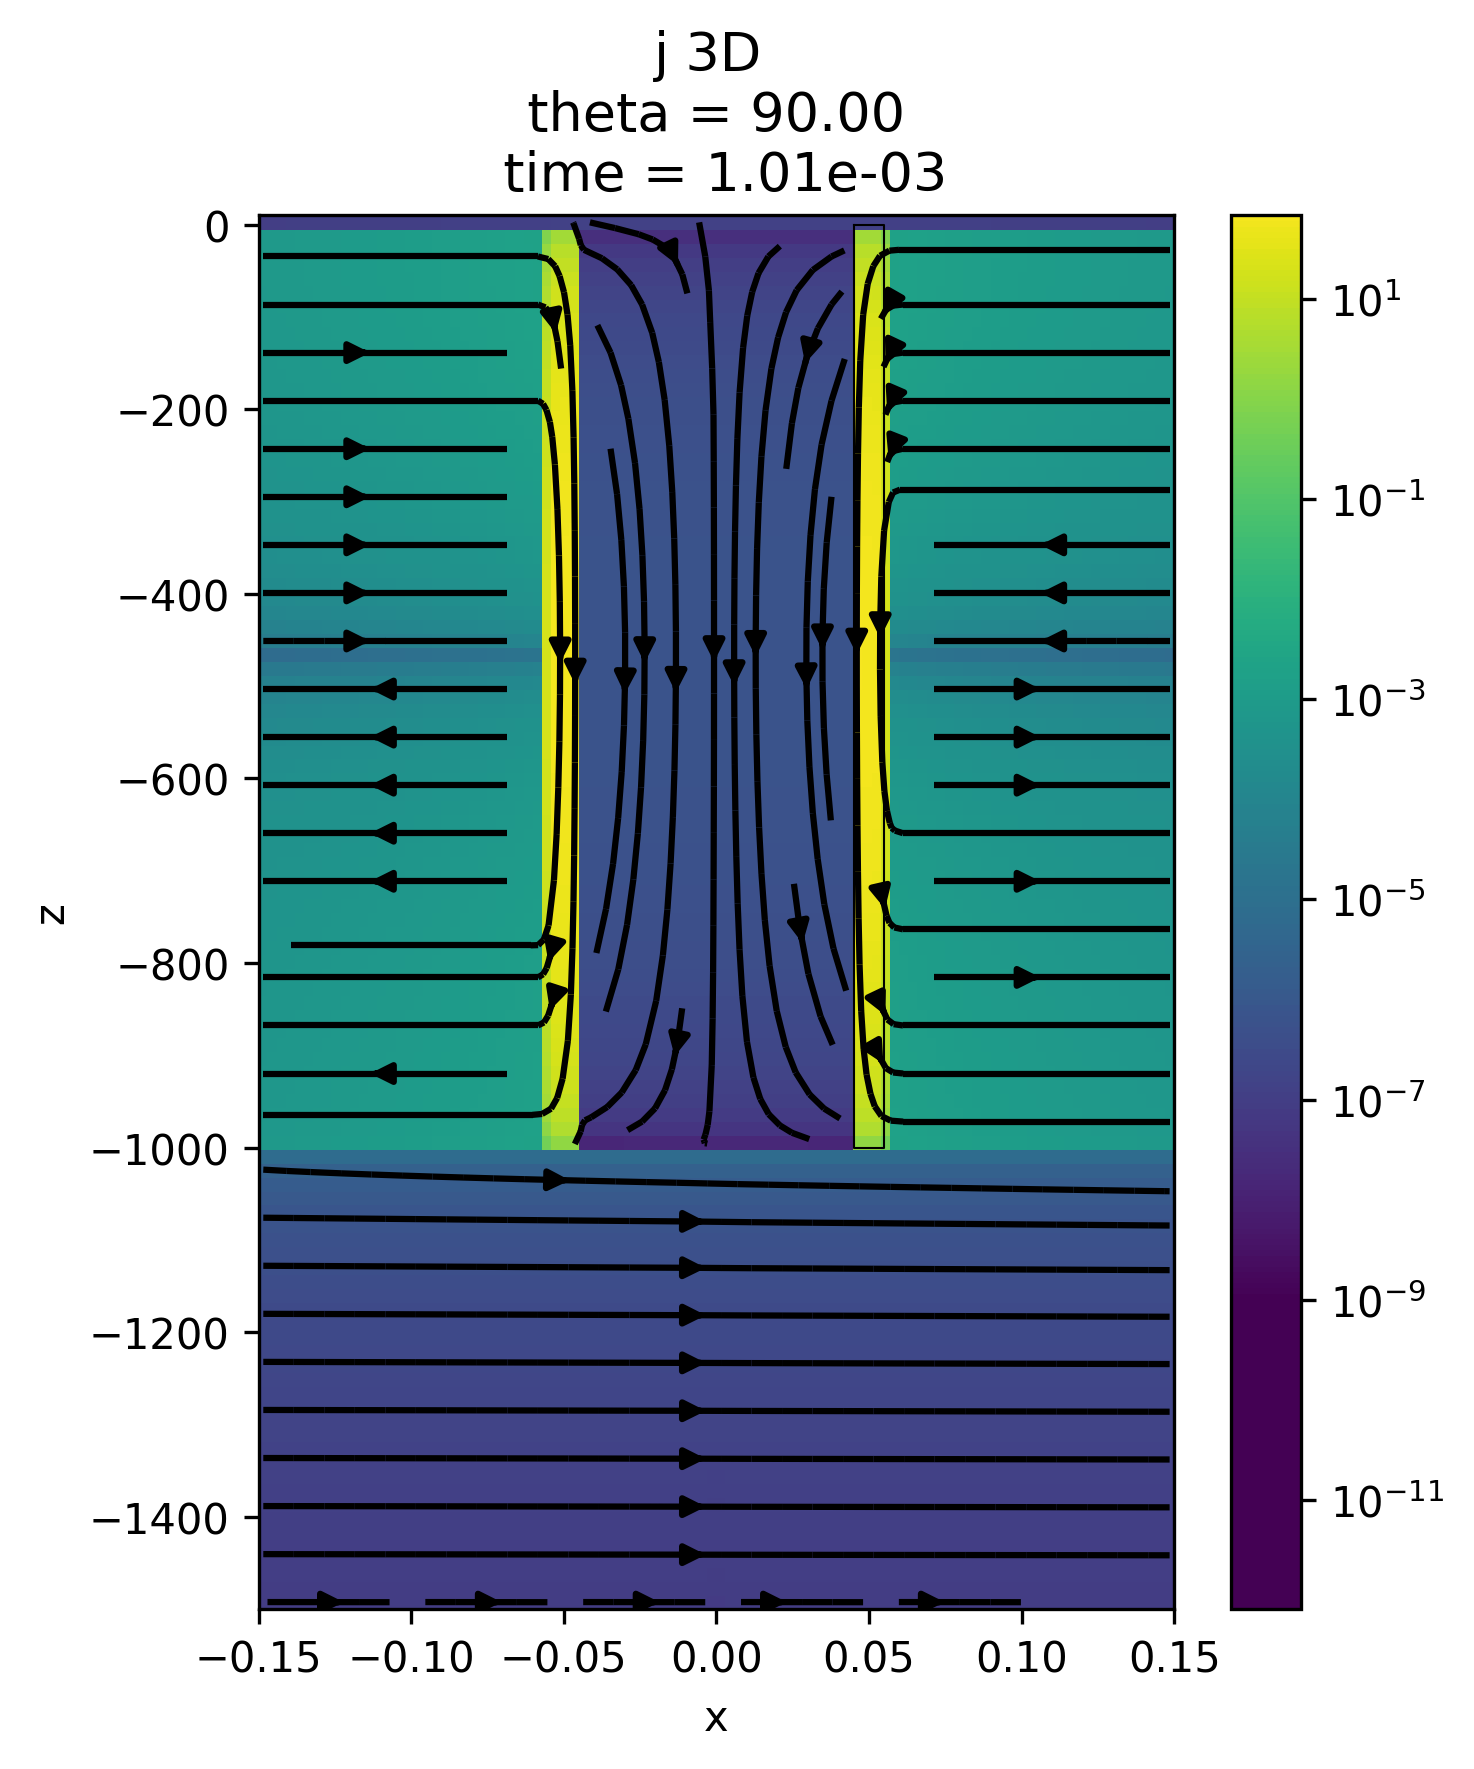

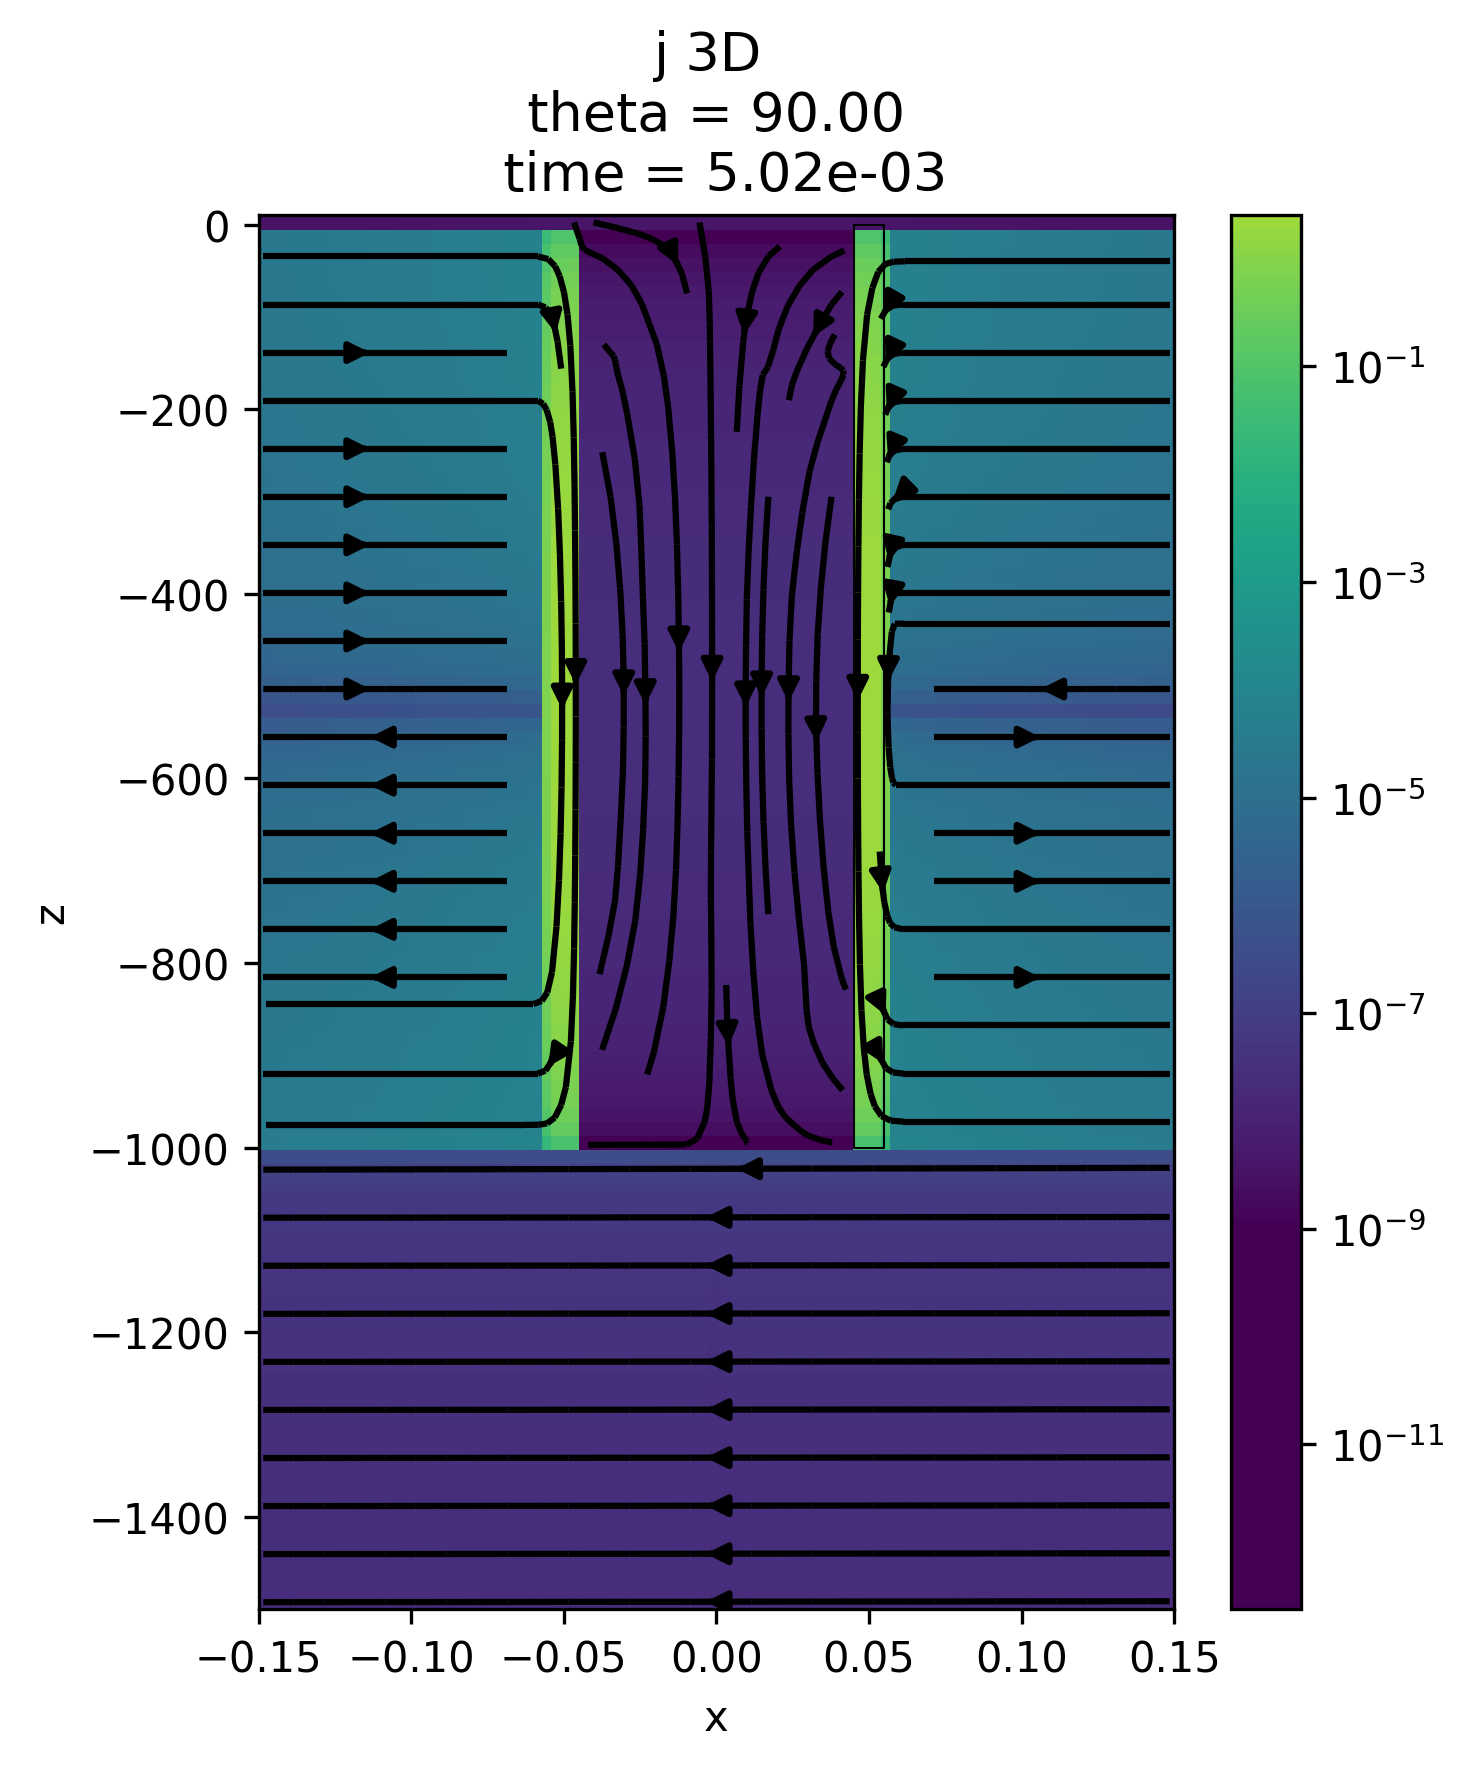

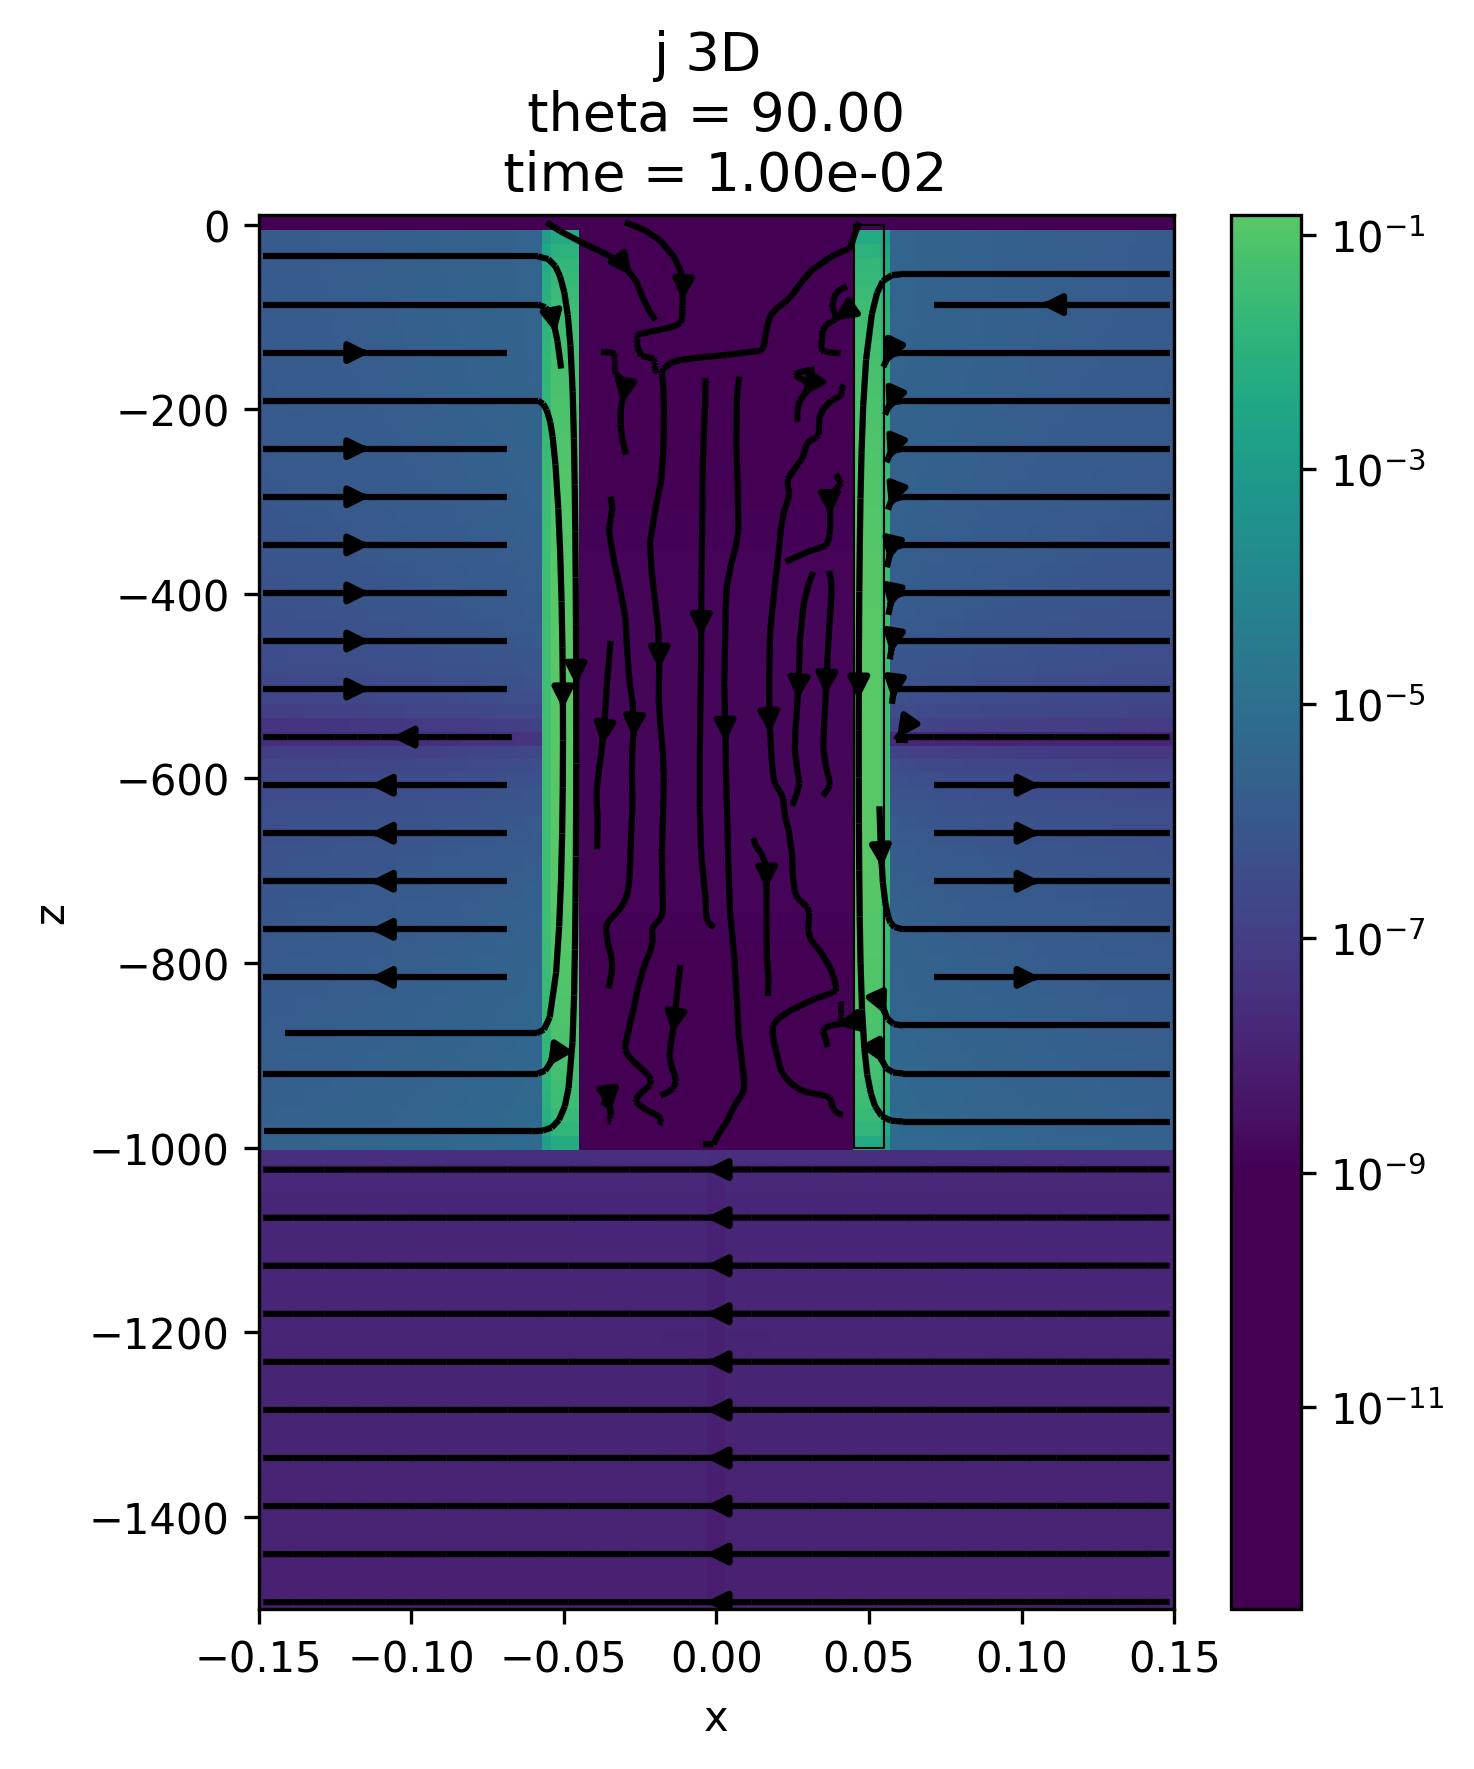

In [44]:
mod = ['3D']

for tind in [0, 10, 28, 73, 118, 136]:
# tind = 136
    fig, ax = plt.subplots(1, len(mod), figsize=(5*len(mod), 6), dpi=300)
    if len(mod) == 1:
        ax = [ax]

    for a, m in zip(ax, mod): 
        a = plotCasingResults(
            ax = a,
            clim_max=1e2, clim_min=1e-9, 
            max_depth=1.5*model.casing_l, 
            max_r=0.15, top=10, view='j',
            casing_outline=True, 
            theta_ind=3,
            time_ind=tind,
            mod=m
        )

    plt.tight_layout()
    plt.show()